**Ход исследования:**

1. [Подготовка данных](#data_preparation)
2. [Функции извлечения данных из текста](#search_function)
3. [Извлечение данных](#data_extraction)
4. [Обработка аномалий](#anomaly_processing)
5. [Исследовательский анализ данных](#exploratory_data_analysis)
6. [Общий вывод](#conclusion)

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Шаг 1. <a id="data_preparation">Подготовка данных</a> 

In [2]:
df = pd.read_csv("C:\\Users\\Ilya\\Documents\\Обучение\\\Сайты судов\\\Проект итог\\analysis_of_court_decisions.csv")
dev_df = pd.read_csv("C:\\Users\\Ilya\\Documents\\Обучение\\\Сайты судов\\\Проект итог\\developers.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2101 entries, 0 to 2100
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   court_name  2101 non-null   object
 1   entryDate   2101 non-null   object
 2   resultDate  2101 non-null   object
 3   decision    2101 non-null   object
 4   text        2101 non-null   object
dtypes: object(5)
memory usage: 82.2+ KB


In [4]:
df.head(5)

,court_name,entryDate,resultDate,decision,text
0,Краснокамский городской суд Пермского края,22.09.2023,11.01.2024,"Иск (заявление, жалоба) УДОВЛЕТВОРЕН ЧАСТИЧНО",Дело № РЕШЕНИЕ Именем Российской Федерации <ад...
1,Краснокамский городской суд Пермского края,14.12.2023,12.03.2024,"Иск (заявление, жалоба) УДОВЛЕТВОРЕН ЧАСТИЧНО",№ ЗАОЧНОЕ РЕШЕНИЕ Именем Российской Федерации ...
2,Соликамский городской суд Пермского края,07.11.2023,28.11.2023,"Иск (заявление, жалоба) УДОВЛЕТВОРЕН",№ 2-2797/2023 <данные изъяты> Р Е Ш Е Н И Е Им...
3,Осинский районный суд Пермского края,09.10.2024,11.11.2024,"Иск (заявление, жалоба) УДОВЛЕТВОРЕН",<данные изъяты> УИД: 59RS0030-01-2024-001515-8...
4,Осинский районный суд Пермского края,15.10.2024,02.11.2024,"Передано по подсудности, подведомственности",<данные изъяты> УИД: 59RS0030-01-2024-001556-6...


In [5]:
dev_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   developer_name  131 non-null    object
 1   group_name      131 non-null    object
 2   inn             131 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 3.2+ KB


In [6]:
dev_df.head(5)

,developer_name,group_name,inn
0,ООО ДСК-СТРОЙ,ДСК-СТРОЙ,1840027673
1,ООО НОВЫЙ ЗВЕЗДНЫЙ,Новый Звездный,5902061480
2,ООО СЗ - МИНИПОЛИС КУЛТАЕВО ПАРК,Култаево парк,5904397550
3,ООО СЗ 1000 ЭТАЖЕЙ,1000 этажей,1800005240
4,ООО СЗ АЗУРИТ,Родонит-инвест,5903143471


In [7]:
# выбираем нужные статус дела
df['decision'].unique()

array(['Иск (заявление, жалоба) УДОВЛЕТВОРЕН ЧАСТИЧНО',
       'Иск (заявление, жалоба) УДОВЛЕТВОРЕН',
       'Передано по подсудности, подведомственности',
       'Заявление ВОЗВРАЩЕНО заявителю',
       'ОТКАЗАНО в удовлетворении иска (заявлении, жалобы)',
       'Производство по делу ПРЕКРАЩЕНО',
       'Иск (заявление, жалоба) ОСТАВЛЕН БЕЗ РАССМОТРЕНИЯ',
       'Дело присоединено к другому делу',
       'ОТКАЗАНО в принятии заявления'], dtype=object)

In [8]:
# фильтруем только выигранные дела
filtered_df = df.query('decision in ["Иск (заявление, жалоба) УДОВЛЕТВОРЕН ЧАСТИЧНО", "Иск (заявление, жалоба) УДОВЛЕТВОРЕН"]')

In [9]:
# фильтруем только дела с застройщиками
filtered_df = filtered_df[
    filtered_df['text'].str.contains(r'\bзастройщик\b', case=False, na=False) & 
    (filtered_df['text'] != '-')
].reset_index(drop=True)

In [10]:
# отфильтруем дела где к тексте определение, а не решение суда
filtered_df = filtered_df[
    ~filtered_df['text'].str.contains(r'[оО][\sПпРрЕеДдЛлИи]+[лЛ][:]', case=False, na=False)].reset_index(drop=True)

In [11]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 662 entries, 0 to 661
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   court_name  662 non-null    object
 1   entryDate   662 non-null    object
 2   resultDate  662 non-null    object
 3   decision    662 non-null    object
 4   text        662 non-null    object
dtypes: object(5)
memory usage: 26.0+ KB


In [12]:
# приводим заголовки к змеиному стилю
filtered_df = filtered_df.rename(columns={'entryDate': 'entry_date', 'resultDate': 'result_date'})

In [13]:
# преобразование данных о времени
filtered_df['entry_date'] = pd.to_datetime(filtered_df['entry_date'], format='%d.%m.%Y')
filtered_df['result_date'] = pd.to_datetime(filtered_df['result_date'], format='%d.%m.%Y')

In [14]:
# проверяем решения каких судов у нас остались
filtered_df['court_name'].unique()

array(['Соликамский городской суд Пермского края',
       'Индустриальный районный суд города Перми',
       'Дзержинский районный суд г. Перми',
       'Свердловский районный суд г. Перми',
       'Ленинский районный суд города Перми',
       'Мотовилихинский районный суд г. Перми',
       'Пермский районный суд Пермского края',
       'Орджоникидзевский районный суд г. Перми',
       'Кировский районный суд г. Перми',
       'Березниковский городской суд Пермского края'], dtype=object)

In [15]:
# посмотрим даты решений суда
print(f'''
Самый ранний поданный иск: {filtered_df['entry_date'].min()}
Самый поздний поданный иск: {filtered_df['entry_date'].max()}
Самое ранее решение суда: {filtered_df['result_date'].min()}
Самое позднее решение суда: {filtered_df['result_date'].max()}
''')


Самый ранний поданный иск: 2022-02-28 00:00:00
Самый поздний поданный иск: 2024-09-12 00:00:00
Самое ранее решение суда: 2023-11-02 00:00:00
Самое позднее решение суда: 2024-11-18 00:00:00



In [16]:
filtered_df.head(5)

,court_name,entry_date,result_date,decision,text
0,Соликамский городской суд Пермского края,2023-11-07,2023-11-28,"Иск (заявление, жалоба) УДОВЛЕТВОРЕН",№ 2-2797/2023 <данные изъяты> Р Е Ш Е Н И Е Им...
1,Индустриальный районный суд города Перми,2023-07-28,2024-04-24,"Иск (заявление, жалоба) УДОВЛЕТВОРЕН ЧАСТИЧНО",<данные изъяты> (59RS0002-01-2023-003521-95) К...
2,Индустриальный районный суд города Перми,2023-03-23,2023-12-12,"Иск (заявление, жалоба) УДОВЛЕТВОРЕН",<данные изъяты> (59RS0002-01-2023-001310-35) Р...
3,Индустриальный районный суд города Перми,2024-05-15,2024-10-22,"Иск (заявление, жалоба) УДОВЛЕТВОРЕН ЧАСТИЧНО",<данные изъяты> - 2547/2024 ( 59RS0002-01-2024...
4,Индустриальный районный суд города Перми,2024-01-29,2024-06-26,"Иск (заявление, жалоба) УДОВЛЕТВОРЕН ЧАСТИЧНО",<данные изъяты> (59RS0002-01-2024-000562-64) Р...


**Вывод:** После фильтрации в нашем распоряжении осталось 662 обезличенных судебных решения, содержащих тексты и информацию о застройщиках-ответчиках. Доступны данные о датах начала разбирательства и вынесения решения, а также отдельный датасет с наименованиями застройщиков.

### Шаг 2. <a id="search_function">Функции извлечения данных из текста</a> 

**Задача:** Необходимо разработать четыре функции для поиска и извлечения сумм из текстов судебных решений. Три из них сравнительно простые:
* Извлечение площади квартиры.
* Извлечение количества комнат.
* Извлечение номеров ИНН застройщиков (юридических лиц) для их дальнейшей идентификации.

Ключевая функция – извлечение сумм заявленных требований и фактически взысканных компенсаций. Какие суммы необходимо найти:
1. Компенсация за дефекты - основная сумма требований, от размера которой зависят расчёты неустоек и штрафов.
2. Компенсация за моральный вред - дополнительное требование, размер которого зависит от количества истцов (дольщиков).
3. Неустойка, штраф - дополнительные суммы, на взыскание которых действовал мораторий с марта 2024 года по декабрь 2024 года, а также с марта 2022 года по июль 2023 года. Из-за этого часть решений не содержит этих сумм.
4. Расходы на досудебную экспертизу – в большинстве случаев удовлетворяются полностью, за исключением ситуаций, когда истец не уточнял требования после судебной экспертизы. В таких случаях сумма рассчитывается пропорционально удовлетворённому требованию за дефекты.
5. Расходы на составление претензии – как правило, суд отказывает в их взыскании.
6. Расходы на представителя в суде – включаются в анализ.

Судебное решение состоит из **двух частей**:
* Первая часть описывает ход процесса и содержит заявленные требования.
* Вторая часть содержит итоговое судебное решение с взысканными суммами.

Таким образом, поиск сумм должен учитывать контекст: **до и после части** где "суд решил". Дополнительные особенности:
* После числовых значений указывается валюта, а для корректного отнесения суммы к определённому типу требований используются ключевые слова.
* Исключаются суммы, которые суд постановил снизить или не приводить в исполнение. Используются слова исключения.
* В решениях суда суммы нередко распределяются по долям собственности, поэтому значения необходимо суммировать (за исключением расходов, которые несёт один истец).
* Как правило, первая указанная сумма – это сумма заявленных требований, а далее в тексте приводятся аргументы для её уменьшения.

Сумма требований за компенсацию дефектов может многократно дублироваться в тексте (до суда заявлялась одна сумма, после судебной экспертизы – вторая, застройщик добровольно выплатил третью, остаток составил четвертую и т. д.). Было принято решение для извлечения использовать **максимальную сумму.**

Проиллюстрируем три сценария:

* Требование 200 тыс. руб., по судебной экспертизе подтверждено 150 тыс. руб. Во второй части(взыскание) решения будет - 150 тыс. руб., в первой части(требование) 200 тыс. руб. как максимальная сумма.
* Требование 200 тыс. руб., застройщик не требовал судебную экспертизу, удовлетворили полностью. Во второй части будет - 200 тыс. руб. как и в первой части.
* Требование 200 тыс. руб., по итогам судебной экспертизы посчитали 250 тыс. руб., поэтому уточнились на эту же сумму. Во второй части будет - 250 тыс. руб., как и в первой части(берём максимальную).

Во втором и третьем сценарии суммы требований и взыскания полностью совпадают. Такие решения суда нужно будет **отфильтровать и исключить из анализа**, их объем предполагается небольшим - досудебные экспертизы чаще всего завышают суммы, и если не достигнуто мировое соглашение, ответчики требуют независимого подтверждения. В остальных случаях застройщик вероятно уже не ведет деятельность и не участвует в суде.

In [17]:
def extract_amount(
    text, 
    start_str_list, 
    end_str='руб', 
    before_str_list=None, 
    after_str_list=None, 
    calculate_sum=False, 
    exclude=None, 
    debug=False, 
    return_max=False
):
    try:
        if pd.isna(text):
            return np.nan

        # перевод текста в нижний регистр
        text = text.lower()

        # ограничение области поиска по after_str_list (ищем только после заданной строки)
        if after_str_list:
            for after_str in after_str_list:
                after_position = text.find(after_str)
                if after_position != -1:
                    text = text[after_position + len(after_str):]
                    break

        # ограничение области поиска по before_str_list (ищем только до заданной строки)
        if before_str_list:
            for before_str in before_str_list:
                before_position = text.find(before_str)
                if before_position != -1:
                    text = text[:before_position]
                    break

        total_sum = 0
        amounts_with_positions = []

        # перебор списка start_str для поиска всех вхождений
        for start_str in start_str_list:
            start_position = text.find(start_str)
            while start_position != -1:
                substring = text[start_position:start_position + 120]  # увеличенная длина для поиска суммы

                if exclude:
                    if any(exc in substring for exc in exclude):
                        start_position = text.find(start_str, start_position + len(start_str))
                        continue  # пропускаем текущее значение, если найдено исключение

                # используется для проверки работы функции
                if debug:
                    print(f"Проверяем фрагмент:\n{substring}")

                # регулярное выражение для поиска суммы после найденной строки
                pattern = rf"(?<!\d)(\d{{1,3}}(?:[ \,]?\d{{3}})*(?:[\,\.]\s?\d{{1,2}})?)(?=\s*{re.escape(end_str)}[., ]?)"
                match = re.search(pattern, substring)

                if match:
                    value = float(match.group(1).replace(' ', '').replace(',', '.'))
                    absolute_position = start_position + len(start_str) + match.start()
                    # сохраняем найденное значение и его абсолютную позицию
                    amounts_with_positions.append((value, absolute_position))

                    # используется для проверки работы функции
                    if debug:
                        print(f"Найдено значение: {value}")

                # ищем следующее вхождение строки
                start_position = text.find(start_str, start_position + len(start_str))

        # если суммы найдены, сортируем по позиции в тексте
        if amounts_with_positions:
            amounts_with_positions.sort(key=lambda x: x[1])  # сортировка по позиции

            # используется для проверки работы функции
            if debug:
                    print(f"Позиции в тексте: {amounts_with_positions}")

            if calculate_sum:
                total_sum = sum(value for value, _ in amounts_with_positions)
                # используется для проверки работы функции
                if debug:
                    print(f"Общая сумма: {total_sum}")
                return total_sum if total_sum > 0 else np.nan
            
            elif return_max:
                max_value = max(amount[0] for amount in amounts_with_positions) # максимальное значение
                if debug:
                    print(f"Максимальное значение: {max_value}")
                return max_value
            else:
                first_value = amounts_with_positions[0][0]  # первое значение по позиции
                # используется для проверки работы функции
                if debug:
                    print(f"Первое значение: {first_value}")
                return first_value

        return np.nan
    except Exception as e:
        print(f"Ошибка: {e}")
        return np.nan

In [18]:
def extract_inn_related_number(text):
    try:
        if pd.isna(text):
            return np.nan
        
        # паттерн для поиска числа рядом с "ИНН" (до или после)
        pattern = r"(?:\b(\d{10})\D{0,2}ИНН)|(?:ИНН\D{0,2}(\d{10}))"
        match = re.search(pattern, text)
        
        if match:
            # возвращаем первое найденное число
            return int(match.group(1) or match.group(2))
        
        return np.nan
    except Exception as e:
        print(f"Ошибка: {e}")
        return np.nan

In [19]:
def extract_rooms_number(text):
    # регулярное выражение для поиска количества комнат
    match = re.search(r'(\d+)-комнат', text)
    if match:
        return int(match.group(1))
    return np.nan

In [20]:
def extract_apartment_area(text):
    # регулярное выражение для поиска площади
    match = re.search(r'(\d{1,3}(?:[.,]\d{1,2})?)\s?кв\.?\s?м', text)
    if match:
        # преобразуем найденное значение в float
        return float(match.group(1).replace(',', '.'))
    return np.nan

### Шаг 3. <a id="data_extraction">Извлечение данных</a> 

#### Шаг 3.1. Определяем ответчиков

In [21]:
filtered_df['inn'] = filtered_df['text'].apply(extract_inn_related_number)

In [22]:
# приводим данные к нужному типу
filtered_df['inn'] = filtered_df['inn'].astype('Int64')

In [23]:
# сопоставляем найденные ИНН и названия групп компаний застройщиков
def find_developer_name(inn_value, df2):
    match = df2.loc[df2['inn'] == inn_value, 'group_name']
    return match.values[0] if not match.empty else None

In [24]:
filtered_df['developer_name'] = filtered_df['inn'].apply(lambda x: find_developer_name(x, dev_df))
filtered_df = filtered_df.drop(columns=['inn'])

In [25]:
filtered_df[filtered_df['developer_name'].notna()].head(5)

,court_name,entry_date,result_date,decision,text,developer_name
1,Индустриальный районный суд города Перми,2023-07-28,2024-04-24,"Иск (заявление, жалоба) УДОВЛЕТВОРЕН ЧАСТИЧНО",<данные изъяты> (59RS0002-01-2023-003521-95) К...,ИнГрупп
2,Индустриальный районный суд города Перми,2023-03-23,2023-12-12,"Иск (заявление, жалоба) УДОВЛЕТВОРЕН",<данные изъяты> (59RS0002-01-2023-001310-35) Р...,ОрсоГрупп
5,Индустриальный районный суд города Перми,2023-10-17,2024-02-26,"Иск (заявление, жалоба) УДОВЛЕТВОРЕН ЧАСТИЧНО",<данные изъяты> <данные изъяты> РЕШЕНИЕ Именем...,Терра
9,Индустриальный районный суд города Перми,2023-02-28,2023-12-22,"Иск (заявление, жалоба) УДОВЛЕТВОРЕН ЧАСТИЧНО",<данные изъяты> (59RS0002-01-2023-000891-31) Р...,Ясно
11,Индустриальный районный суд города Перми,2023-07-05,2024-05-13,"Иск (заявление, жалоба) УДОВЛЕТВОРЕН ЧАСТИЧНО",<данные изъяты> (59RS0002-01-2023-003156-26) К...,Горизонт


#### Шаг 3.2. Определяем количество комнат в квартирах

In [26]:
filtered_df['rooms'] = filtered_df['text'].apply(extract_rooms_number)
filtered_df['rooms'] = filtered_df['rooms'].astype('Int64')
filtered_df[filtered_df['rooms'].notna()].head(5)

,court_name,entry_date,result_date,decision,text,developer_name,rooms
10,Индустриальный районный суд города Перми,2024-02-29,2024-10-04,"Иск (заявление, жалоба) УДОВЛЕТВОРЕН ЧАСТИЧНО",<данные изъяты> (59RS0002-01-2024-001391-02) Р...,None,1
15,Дзержинский районный суд г. Перми,2024-01-09,2024-07-22,"Иск (заявление, жалоба) УДОВЛЕТВОРЕН ЧАСТИЧНО",<данные изъяты> Уникальный идентификатор дела ...,None,1
22,Дзержинский районный суд г. Перми,2024-03-22,2024-09-04,"Иск (заявление, жалоба) УДОВЛЕТВОРЕН ЧАСТИЧНО",<данные изъяты> Уникальный идентификатор дела ...,None,1
23,Дзержинский районный суд г. Перми,2023-01-24,2024-01-19,"Иск (заявление, жалоба) УДОВЛЕТВОРЕН ЧАСТИЧНО",<данные изъяты> (2-1139/2023) <данные изъяты> ...,None,2
24,Дзержинский районный суд г. Перми,2022-12-27,2024-02-08,"Иск (заявление, жалоба) УДОВЛЕТВОРЕН ЧАСТИЧНО",<данные изъяты> (2-902/2023) <данные изъяты> Р...,None,1


#### Шаг 3.3. Определяем площадь квартир

In [27]:
filtered_df['area'] = filtered_df['text'].apply(extract_apartment_area)
filtered_df['area'] = filtered_df['area']
filtered_df[filtered_df['area'].notna()].head(5)

,court_name,entry_date,result_date,decision,text,developer_name,rooms,area
1,Индустриальный районный суд города Перми,2023-07-28,2024-04-24,"Иск (заявление, жалоба) УДОВЛЕТВОРЕН ЧАСТИЧНО",<данные изъяты> (59RS0002-01-2023-003521-95) К...,ИнГрупп,<NA>,954.00
3,Индустриальный районный суд города Перми,2024-05-15,2024-10-22,"Иск (заявление, жалоба) УДОВЛЕТВОРЕН ЧАСТИЧНО",<данные изъяты> - 2547/2024 ( 59RS0002-01-2024...,None,<NA>,44.60
4,Индустриальный районный суд города Перми,2024-01-29,2024-06-26,"Иск (заявление, жалоба) УДОВЛЕТВОРЕН ЧАСТИЧНО",<данные изъяты> (59RS0002-01-2024-000562-64) Р...,None,<NA>,56.60
5,Индустриальный районный суд города Перми,2023-10-17,2024-02-26,"Иск (заявление, жалоба) УДОВЛЕТВОРЕН ЧАСТИЧНО",<данные изъяты> <данные изъяты> РЕШЕНИЕ Именем...,Терра,<NA>,45.79
7,Индустриальный районный суд города Перми,2024-01-09,2024-04-24,"Иск (заявление, жалоба) УДОВЛЕТВОРЕН ЧАСТИЧНО",<данные изъяты> (59RS0002-01-2024-000032-05) Р...,None,<NA>,1.00


#### Шаг 3.3. Определяем сумму требований

In [28]:
# cписок ключевых слов: расходы на экспертизу
expert_costs_keywords = ['проведение экспертизы', 'услуг специалиста', 'услуг эксперта', 'услуги специалиста',
                         'расходы по экспертизе', 'услуги эксперта', 'проведение оценки', 'расходы по оплате экспертизы',
                        'подготовке заключения', 'экспертных услуг', 'затрат на проведение', 'подготовки экспертного заключения',
                        'подготовки заключения', 'судебные расходы по оплате оценки', 'расходов по оплате отчета',
                         'проведением экспертизы', 'заключения эксперта', 'за экспертизу истец оплатил']
expert_costs_exclude = ['снизить']

# cписок ключевых слов: расходы на претензию
pretrial_claim_costs_keywords = ['на подготовку', 'судебные расходы на составление претензии']
pretrial_claim_costs_exclude = ['заключения', 'отчета']

# cписок ключевых слов: расходы на юриста
laweyr_costs_keywords = ['представителя', 'судебные расходы по оплате услуг', 'судебные расходы по оплате юридических услуг',
                         'судебные расходы на оплату услуг', 'платой юридических услуг']
laweyr_costs_exclude = ['неустойка', 'подготовку претензии', 'с учетом требований разумности', 'не должен превышать']

# cписок ключевых слов: судебные расходы
court_costs_keywords = ['судебные расходы']
court_costs_exclude = ['судебные расходы по оплате оценки', 'судебные расходы на составление претензии', 'судебные расходы по оплате услуг',
                        'судебные расходы по оплате юридических услуг', 'судебные расходы на оплату услуг', 'судебные расходы по оплате экспертизы']

# cписок ключевых слов: компенсация за дефекты
defect_compensation_keywords = ['недостатков', 'дефектов', 'уменьшения цены договора', 'возмещение ущерба', 'возмещения ущерба', 'соразмерном уменьшении цены']
defect_compensation_exclude = ['%', 'за каждый день', 'по день фактической', 'исполнению', 'исполнение' , 'выплатой ответчиком', 'с дата по дата']


# cписок ключевых слов: компенсация за моральный вред
moral_damage_keywords = ['морального вреда']
moral_damage_exclude = ['соразмерной', 'снизить']

# cписок ключевых слов: компенсация за неустойку
liquidated_keywords = ['неустойку']
liquidated_exclude = ['за каждый день', '% от суммы', 'исходя из расчета', 'отсрочка', 'отсрочку']

# cписок ключевых слов: компенсация за штраф
penalty_keywords = ['штраф']
penalty_exclude = ['несоразмерен', '% от присужденной', 'снизить', 'отсрочка', 'отсрочку']

# ограничение для поиска в тексте решения
before_keywords_demand = ['решил:', 'р е ш и л:', 'суд решил :', '194-199', '194 - 199', '194–199', '194-198', '194–198', '194 - 198', '194 – 198', '194 – 199']
after_keywords_demand = ['письменной претензией', 'направлена претензия', 'направил ответчику претензию с требовани', 'претензию с требовани', 'направлена в адрес ответчика претензия']

before_keywords_recovery = ['решение суда в части', 'решение в части', 'исполненной части']
after_keywords_recovery = ['решил:', 'р е ш и л:', 'суд решил :', '194-199', '194 - 199', '194–199', '194-198', '194–198', '194 - 198', '194 – 198', '194 – 199']

In [29]:
filtered_df['expert_costs_demand'] = filtered_df['text'].apply(
    extract_amount, 
    start_str_list=expert_costs_keywords, 
    before_str_list=before_keywords_demand,
    exclude=expert_costs_exclude
)

In [30]:
filtered_df['pretrial_claim_costs_demand'] = filtered_df['text'].apply(
    extract_amount, 
    start_str_list=pretrial_claim_costs_keywords, 
    before_str_list=before_keywords_demand, 
    exclude=pretrial_claim_costs_exclude
)

In [31]:
filtered_df['laweyr_costs_demand'] = filtered_df['text'].apply(
    extract_amount, 
    start_str_list=laweyr_costs_keywords, 
    before_str_list=before_keywords_demand,
    exclude=laweyr_costs_exclude
)

In [32]:
filtered_df['defect_compensation_demand'] = filtered_df['text'].apply(
    extract_amount, 
    start_str_list=defect_compensation_keywords, 
    before_str_list=before_keywords_demand,
    exclude=defect_compensation_exclude,
    return_max=True
)

Ошибка: could not convert string to float: '73.080.53'


In [33]:
filtered_df['moral_damage_demand'] = filtered_df['text'].apply(
    extract_amount, 
    start_str_list=moral_damage_keywords, 
    before_str_list=before_keywords_demand, 
    exclude=moral_damage_exclude
)

#### Шаг 3.4. Определяем сумму к взысканию

In [34]:
filtered_df['expert_costs_recovery'] = filtered_df['text'].apply(
    extract_amount, 
    start_str_list=expert_costs_keywords, 
    after_str_list=after_keywords_recovery,
    exclude=expert_costs_exclude,
    calculate_sum=False
)

In [35]:
filtered_df['pretrial_claim_costs_recovery'] = filtered_df['text'].apply(
    extract_amount, 
    start_str_list=pretrial_claim_costs_keywords, 
    after_str_list=after_keywords_recovery,
    calculate_sum=False,
    exclude=pretrial_claim_costs_exclude
)

In [36]:
filtered_df['laweyr_costs_recovery'] = filtered_df['text'].apply(
    extract_amount, 
    start_str_list=laweyr_costs_keywords, 
    after_str_list=after_keywords_recovery,
    calculate_sum=False
)

In [37]:
filtered_df['court_costs_recovery'] = filtered_df['text'].apply(
    extract_amount, 
    start_str_list=court_costs_keywords, 
    after_str_list=after_keywords_recovery,
    exclude=court_costs_exclude,
    calculate_sum=False
)

In [38]:
filtered_df['defect_compensation_recovery'] = filtered_df['text'].apply(
    extract_amount, 
    start_str_list=defect_compensation_keywords, 
    after_str_list=after_keywords_recovery,
    exclude=defect_compensation_exclude,
    calculate_sum=True
)

In [39]:
filtered_df['moral_damage_recovery'] = filtered_df['text'].apply(
    extract_amount, 
    start_str_list=moral_damage_keywords, 
    after_str_list=after_keywords_recovery,
    calculate_sum=True,
    exclude=moral_damage_exclude
)

In [40]:
filtered_df['liquidated_recovery'] = filtered_df['text'].apply(
    extract_amount, 
    start_str_list=liquidated_keywords, 
    after_str_list=after_keywords_recovery,
    calculate_sum=True,
    exclude=liquidated_exclude
)

In [41]:
filtered_df['penalty_recovery'] = filtered_df['text'].apply(
    extract_amount, 
    start_str_list=penalty_keywords,    
    after_str_list=after_keywords_recovery,
    calculate_sum=True,
    exclude=penalty_exclude
)

In [42]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 662 entries, 0 to 661
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   court_name                     662 non-null    object        
 1   entry_date                     662 non-null    datetime64[ns]
 2   result_date                    662 non-null    datetime64[ns]
 3   decision                       662 non-null    object        
 4   text                           662 non-null    object        
 5   developer_name                 353 non-null    object        
 6   rooms                          265 non-null    Int64         
 7   area                           374 non-null    float64       
 8   expert_costs_demand            420 non-null    float64       
 9   pretrial_claim_costs_demand    53 non-null     float64       
 10  laweyr_costs_demand            399 non-null    float64       
 11  defect_compensation

### Шаг 4. <a id="anomaly_processing">Обработка аномалий</a> 

**Задача:** сначала необходимо отфильтровать судебные решения, в которых взысканная сумма компенсации за дефекты равна или превышает заявленную. 
Это позволит исключить:
* Решения, не содержащие взыскания компенсации за дефекты (например, когда спор касался только неустойки за задержку сдачи квартиры).
* Случаи, в которых требуемая сумма была удовлетворена полностью (что указывает на отсутствие независимой экспертизы).

In [43]:
filtered_df = filtered_df.loc[filtered_df['defect_compensation_recovery'] < filtered_df['defect_compensation_demand']]
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 264 entries, 3 to 656
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   court_name                     264 non-null    object        
 1   entry_date                     264 non-null    datetime64[ns]
 2   result_date                    264 non-null    datetime64[ns]
 3   decision                       264 non-null    object        
 4   text                           264 non-null    object        
 5   developer_name                 120 non-null    object        
 6   rooms                          84 non-null     Int64         
 7   area                           161 non-null    float64       
 8   expert_costs_demand            248 non-null    float64       
 9   pretrial_claim_costs_demand    36 non-null     float64       
 10  laweyr_costs_demand            163 non-null    float64       
 11  defect_compensation

**Задача:** проверим излеченные суммы на предмет аномалий

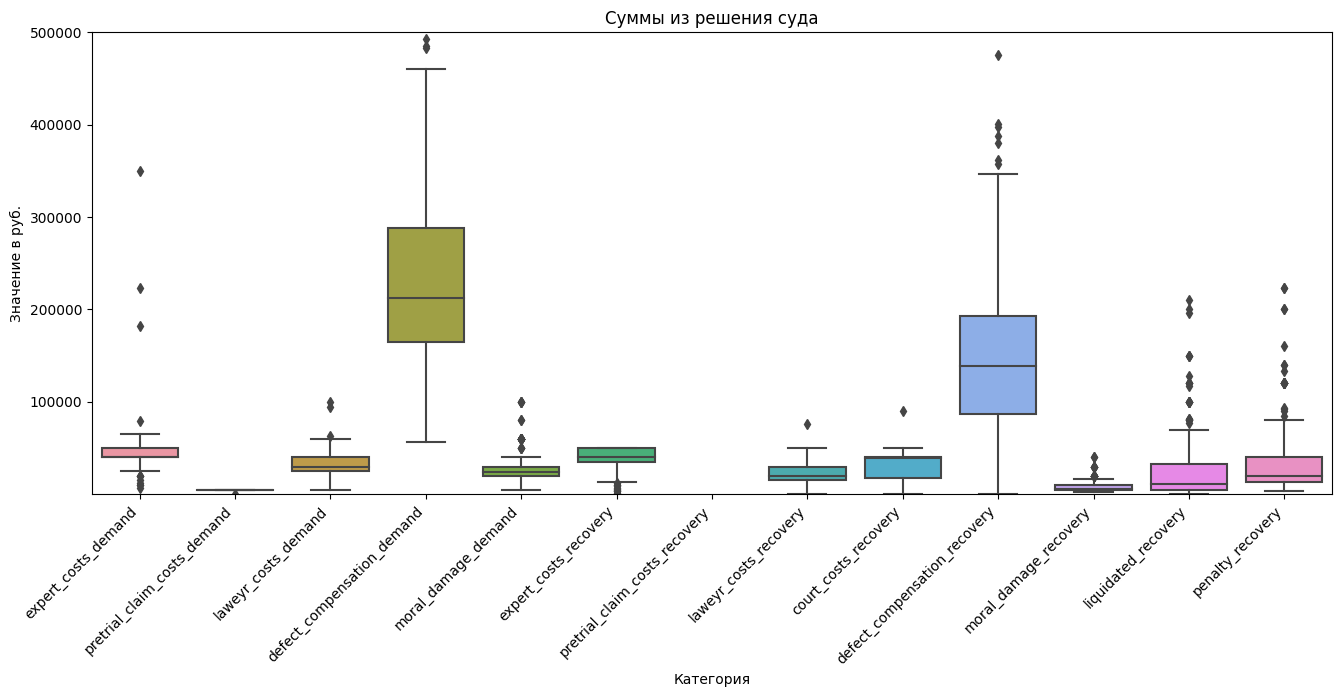

In [44]:
# преобразование DataFrame в "длинный" формат
df_long = filtered_df.loc[:, 'expert_costs_demand':'penalty_recovery'].melt(var_name='сolumns', value_name='values')

# построение boxplot
plt.figure(figsize=(16, 6))
sns.boxplot(x='сolumns', y='values', data=df_long)
plt.title('Суммы из решения суда')
plt.xlabel('Категория')
plt.ylabel('Значение в руб.')
plt.xticks(rotation=45, ha='right')
plt.ylim(1.0, 500000.0)
plt.show()

**Вывод:** выбросы проявляются по-разному в зависимости от типа требований: у некоторых значений наблюдаются как верхние, так и нижние выбросы, а у других — только с одной стороны.
Так как диапазон значений значительно варьируется для разных категорий требований, проверим распределение в меньшем масштабе.

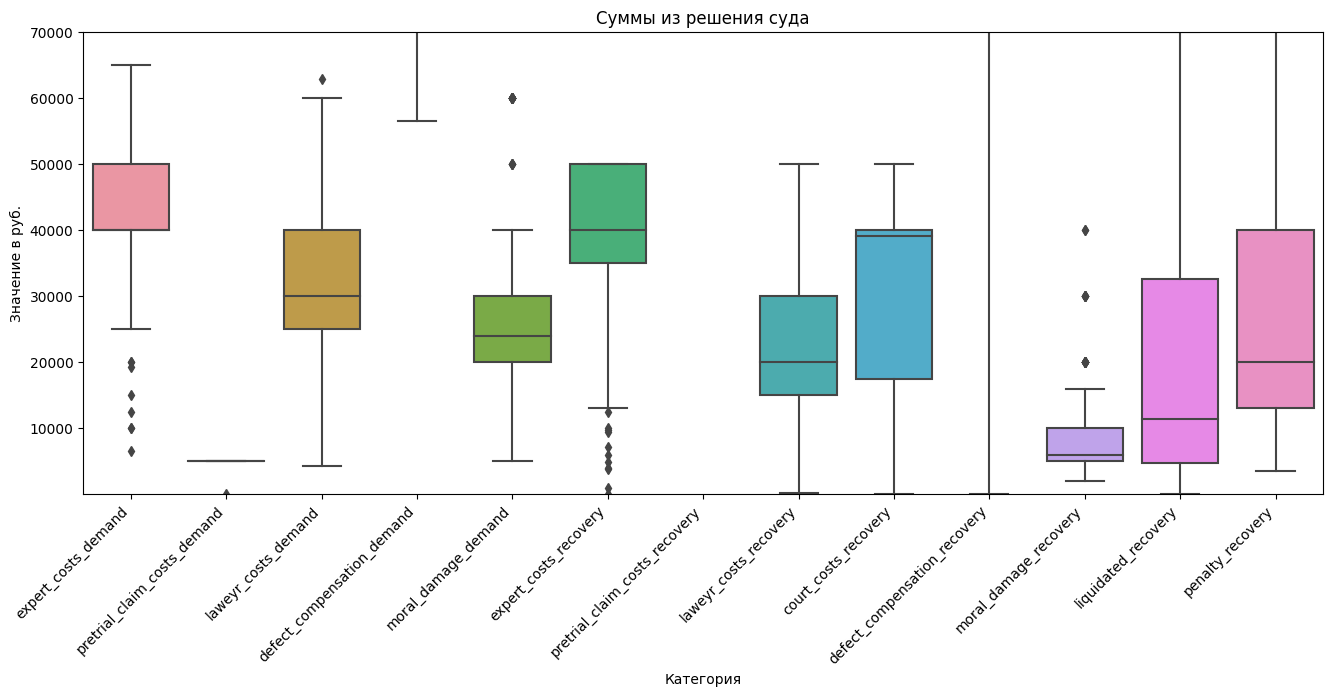

In [45]:
# построение boxplot
plt.figure(figsize=(16, 6))
sns.boxplot(x='сolumns', y='values', data=df_long)
plt.title('Суммы из решения суда')
plt.xlabel('Категория')
plt.ylabel('Значение в руб.')
plt.xticks(rotation=45, ha='right')
plt.ylim(1.0, 70000.0)
plt.show()

**Вывод:** теперь можно сделать выводы по крайним значениям.

Границы нижних/верхних выбросов для требований за:
* расходы на экспертизу - **25 000 / 65 000**
* расходы на претензию - **5 000** / без выбросов более 5 000
* расходы на представителя - без выбросов менее 4 000 / **60 000**
* компенсация за дефекты - без выбросов менее 55 000 / **460 000**
* компенсация за моральный вред - без выбросов менее 5 000 / **40 000**
  
Границы нижних/верхних выбросов для удовлетворенных сумм за:
* расходы на экспертизу - **12 000** / без выбросов более 50 000
* расходы на представителя - нет значения / **50 000**
* компенсация за дефекты - нет значения / **350 000**
* компенсация за моральный вред - без выбросов менее 2 000 / **15 000**
* неустойка - нет значения / **80 000**
* штраф - нет значения / **90 000**

Для взысканных сумм судебных расходов и составления претензий определять границы нецелесообразно из-за небольшого количества данных.

**Задача:** следует выборочно проверить выбросы за все типы расходов и за компенсацию недостатков как основных требований. Остальное можно отфильтровать.

#### Проверка требований и взысканий расходов на экспертизу

In [46]:
filtered_df[(filtered_df['expert_costs_demand'] < 25000) & (filtered_df['expert_costs_demand'].notna())].index

Int64Index([4, 11, 18, 33, 107, 145, 614, 634], dtype='int64')

In [47]:
# тест решения суда
test_text = filtered_df.loc[4, 'text']

# применяем функцию к тексту
result = extract_amount(test_text, start_str_list=expert_costs_keywords, before_str_list=before_keywords_demand, debug=True)
result

Проверяем фрагмент:
проведение экспертизы по указанным реквизитам истца. указанное требование оставлено ответчиком без ответа и удовлетворен
Проверяем фрагмент:
проведение экспертизы путем перечисления денежных средств на указанные банковские реквизиты /л.д.6-7 т.1/. как следует и
Проверяем фрагмент:
услуг специалиста по экспертному исследованию составила 20000,00 руб., что подтверждается договором оказания экспертных 
Найдено значение: 20000.0
Проверяем фрагмент:
экспертных услуг № /л.д.32 оборот-33 т.1/, квитанцией от дд.мм.гггг /л.д.34 т.1/. из содержания искового заявления следу
Позиции в тексте: [(20000.0, 20203)]
Первое значение: 20000.0


20000.0

In [48]:
# тест решения суда
test_text = filtered_df.loc[11, 'text']

# применяем функцию к тексту
result = extract_amount(test_text, start_str_list=expert_costs_keywords, before_str_list=before_keywords_demand, debug=True)
result

Проверяем фрагмент:
проведение экспертизы в размере 15 663,67 руб., а ответчиком дд.мм.гггг выплачена сумма в размере 19 336,33 руб., то ука
Найдено значение: 15663.67
Проверяем фрагмент:
заключения эксперта, что подтверждается платежным поручением № от дд.мм.гггг на сумму 19 336,33 руб. (том 1, л.д. 72,73)
Найдено значение: 19336.33
Проверяем фрагмент:
заключения эксперта № сн-144 от дд.мм.гггг. согласно части 1 статьи 67 гражданского процессуального кодекса российской ф
Проверяем фрагмент:
заключения эксперта <данные изъяты> № от дд.мм.гггг в размере 35 000 руб., что подтверждается договором о проведении стр
Найдено значение: 35000.0
Проверяем фрагмент:
заключения эксперта пропорционально выявленным недостаткам перечислены денежные средства в размере 19 336,33 руб., что п
Найдено значение: 19336.33
Позиции в тексте: [(19336.33, 13568), (35000.0, 32757), (19336.33, 33230), (15663.67, 33791)]
Первое значение: 19336.33


19336.33

In [49]:
15663.67 + 19336.33

35000.0

In [50]:
# здесь в тексте речь о частичной оплате и требовании остатка, а общая сумма равно 35 000 руб.
filtered_df.loc[11, 'expert_costs_demand'] = 35000.0

In [51]:
# тест решения суда
test_text = filtered_df.loc[18, 'text']

# применяем функцию к тексту
result = extract_amount(test_text, start_str_list=expert_costs_keywords, before_str_list=before_keywords_demand, debug=True)
result

Проверяем фрагмент:
услуг специалиста по оценке стоимости замены оконных конструкций. в обоснование иска указано, что дата между ооо «пермск
Проверяем фрагмент:
услуг специалиста составили 6500 рублей, что подтверждается договором возмездного оказания услуг по дата. ссылаясь на по
Найдено значение: 6500.0
Проверяем фрагмент:
услуг специалиста по оценке стоимости замены оконных конструкций 6500 рублей. истцы в судебное заседание не явились, о в
Найдено значение: 6500.0
Проверяем фрагмент:
услуг специалиста по оценке стоимости замены оконных конструкций в размере 6500 рублей. указанная претензия направлена в
Найдено значение: 6500.0
Проверяем фрагмент:
услуг специалиста по оценке стоимости замены оконных конструкций в размере 6500 рублей, которые являются судебными издер
Найдено значение: 6500.0
Проверяем фрагмент:
услуги специалиста в размере 6500 рублей, поскольку участник долевого строительства вправе предъявить к застройщику треб
Найдено значение: 6500.0
Позиции в тексте: [(6500.0, 2

6500.0

In [52]:
# тест решения суда
test_text = filtered_df.loc[33, 'text']

# применяем функцию к тексту
result = extract_amount(test_text, start_str_list=expert_costs_keywords, before_str_list=before_keywords_demand, debug=True)
result

Проверяем фрагмент:
заключения эксперта №э/23 от дата составляет 12 530,50 руб. поскольку вышеуказанные недостатки не являются таковыми, так
Найдено значение: 12530.5
Позиции в тексте: [(12530.5, 7284)]
Первое значение: 12530.5


12530.5

In [53]:
# тест решения суда
test_text = filtered_df.loc[107, 'text']

# применяем функцию к тексту
result = extract_amount(test_text, start_str_list=expert_costs_keywords, before_str_list=before_keywords_demand, debug=True)
result

Проверяем фрагмент:
услуг специалиста удовлетворению не подлежит, так как данные расходы не относятся к убыткам. в соответствии со ст. 98, с
Проверяем фрагмент:
заключения эксперта в размере 20 000 руб. дд.мм.гггг между истцом и ооо «эксперт-р» заключен договор № на выполнение раб
Найдено значение: 20000.0
Позиции в тексте: [(20000.0, 24948)]
Первое значение: 20000.0


20000.0

In [54]:
# тест решения суда
test_text = filtered_df.loc[145, 'text']

# применяем функцию к тексту
result = extract_amount(test_text, start_str_list=expert_costs_keywords, before_str_list=before_keywords_demand, debug=True)
result

Проверяем фрагмент:
услуг эксперта подтверждается квитанцией № от дд.мм.гггг на сумму 10 000 рублей (л.д. 25). суд учитывает, что имуществен
Найдено значение: 10000.0
Проверяем фрагмент:
экспертных услуг. согласно заключения специалиста № от дд.мм.гггг в <адрес> выявлены недостатки строительных работ, указ
Проверяем фрагмент:
экспертных услуг. согласно заключения специалиста № от дд.мм.гггг в <адрес> выявлены недостатки строительных работ, указ
Проверяем фрагмент:
заключения эксперта в размере 10 000 руб. истец фио1 в судебное заседание не явился, о времени и месте судебного разбира
Найдено значение: 10000.0
Проверяем фрагмент:
заключения эксперта в размере 10 000 руб. между истцом и ано «палата судебных экспертиз заключен договор на оказание усл
Найдено значение: 10000.0
Позиции в тексте: [(10000.0, 1901), (10000.0, 15713), (10000.0, 15993)]
Первое значение: 10000.0


10000.0

In [55]:
# тест решения суда
test_text = filtered_df.loc[614, 'text']

# применяем функцию к тексту
result = extract_amount(test_text, start_str_list=expert_costs_keywords, before_str_list=before_keywords_demand, exclude=expert_costs_exclude, debug=True)
result

Проверяем фрагмент:
проведение экспертизы составляет 15 000 рублей. в подтверждение исполнения вышеуказанного договора ип фио5 составлено за
Найдено значение: 15000.0
Проверяем фрагмент:
расходы по оплате экспертизы в размере 15 000 рублей. на основании ст. 94 гпк рф к издержкам, связанным с рассмотрением 
Найдено значение: 15000.0
Проверяем фрагмент:
экспертных услуг, согласно которому исполнитель принял на себя обязательства по определению стоимости работ и материалов
Проверяем фрагмент:
экспертных услуг № от дд.мм.гггг, квитанция № от дд.мм.гггг подлежит частичному удовлетворению в размере 6 000 рублей, в
Найдено значение: 6000.0
Проверяем фрагмент:
затрат на проведение строительно-технической экспертизы в размере 15 000 руб., уплаченных на основании договора возмездн
Найдено значение: 15000.0
Позиции в тексте: [(15000.0, 34299), (15000.0, 36686), (15000.0, 37353), (6000.0, 37521)]
Первое значение: 15000.0


15000.0

In [56]:
# тест решения суда
test_text = filtered_df.loc[634, 'text']

# применяем функцию к тексту
result = extract_amount(test_text, start_str_list=expert_costs_keywords, before_str_list=before_keywords_demand, exclude=expert_costs_exclude, debug=True)
result

Проверяем фрагмент:
экспертных услуг (л.д.19-20). согласно представленному в материалы дела заключению специалиста № от дд.мм.гггг стоимость
Проверяем фрагмент:
экспертных услуг № от дд.мм.гггг и квитанция к приходному кассовому ордеру № от дд.мм.гггг на сумму 10 000 рублей (л.д.1
Найдено значение: 10000.0
Проверяем фрагмент:
заключения эксперта полежат взысканию в пользу <данные изъяты>. истцом также заявлено требования о взыскании судебных ра
Позиции в тексте: [(10000.0, 22601)]
Первое значение: 10000.0


10000.0

In [57]:
filtered_df[(filtered_df['expert_costs_demand'] > 65000) & (filtered_df['expert_costs_demand'].notna())].index

Int64Index([9, 131, 255, 460], dtype='int64')

In [58]:
# тест решения суда
test_text = filtered_df.loc[9, 'text']

# применяем функцию к тексту
result = extract_amount(test_text, start_str_list=expert_costs_keywords, before_str_list=before_keywords_demand, exclude=expert_costs_exclude, debug=True)
result

Проверяем фрагмент:
заключения эксперта ооо «проспект» в размере 223 300, 00 рублей в качестве суммы уменьшения договора. при этом ответчик 
Найдено значение: 223300.0
Позиции в тексте: [(223300.0, 5488)]
Первое значение: 223300.0


223300.0

In [59]:
filtered_df.loc[9, 'expert_costs_demand':'penalty_recovery']

expert_costs_demand               223300.0
pretrial_claim_costs_demand            NaN
laweyr_costs_demand                    NaN
defect_compensation_demand        223300.0
moral_damage_demand                25000.0
expert_costs_recovery                  NaN
pretrial_claim_costs_recovery          NaN
laweyr_costs_recovery                  NaN
court_costs_recovery                   NaN
defect_compensation_recovery      60845.98
moral_damage_recovery               5000.0
liquidated_recovery              120845.98
penalty_recovery                   20000.0
Name: 9, dtype: object

In [60]:
# в фрагменте берется сумма за дефекты, судя по взысканным суммам расходы за экспертизу не требовали(не удовлетворили ни в каком объеме)
filtered_df.loc[9, 'expert_costs_demand'] = np.nan

In [61]:
# тест решения суда
test_text = filtered_df.loc[131, 'text']

# применяем функцию к тексту
result = extract_amount(test_text, start_str_list=expert_costs_keywords, before_str_list=before_keywords_demand, exclude=expert_costs_exclude, debug=True)
result

Проверяем фрагмент:
услуги специалиста в размере 35 000 руб. частью 1 статьи 88 гражданского процессуального кодекса <данные изъяты> федерац
Найдено значение: 35000.0
Проверяем фрагмент:
расходы по экспертизе в размере 350 000 руб. претензия истцов оставлена застройщиком без удовлетворения. фио2, фио3 обра
Найдено значение: 350000.0
Проверяем фрагмент:
заключения эксперта, производственными недостатки являются: отслоение, замятие обоев, что не соответствует п.3.67, 3.12 
Позиции в тексте: [(350000.0, 12893), (35000.0, 30892)]
Первое значение: 350000.0


350000.0

In [62]:
# исправляем опечатку
filtered_df.loc[131, 'expert_costs_demand'] = 35000.0

In [63]:
# тест решения суда
test_text = filtered_df.loc[255, 'text']

# применяем функцию к тексту
result = extract_amount(test_text, start_str_list=expert_costs_keywords, before_str_list=before_keywords_demand, exclude=expert_costs_exclude, debug=True)
result

Проверяем фрагмент:
услуг эксперта не заверена печатью организации, выдавшей ее, не содержит в себе ни ссылок на заключенный договор, ни наи
Проверяем фрагмент:
проведение оценки и получение отчета было необходимо истцу для реализации права на обращение в суд и необходимостью опре
Проверяем фрагмент:
затрат на проведение ип ваа экспертных исследований в досудебном порядке. кроме того, представленная в материалы дела кв
Проверяем фрагмент:
заключения эксперта. ответчик добровольно перечислил истцу денежные средства в размере 79390,24 руб. после подтверждения
Найдено значение: 79390.24
Проверяем фрагмент:
заключения эксперта подтверждается кассовым чеком от дд.мм.гггг на сумму 50 000 руб. и квитанцией к приходному кассовому
Найдено значение: 50000.0
Позиции в тексте: [(79390.24, 4451), (50000.0, 41723)]
Первое значение: 79390.24


79390.24

In [64]:
# здесь в тексте речь о частичной оплате требований, а сумма за экспертизу равна 50 000 руб.
filtered_df.loc[255, 'expert_costs_demand'] = 50000.0

In [65]:
# тест решения суда
test_text = filtered_df.loc[460, 'text']

# применяем функцию к тексту
result = extract_amount(test_text, start_str_list=expert_costs_keywords, before_str_list=before_keywords_demand, exclude=expert_costs_exclude, debug=True)
result

Проверяем фрагмент:
услуг эксперта в размере 50 000 руб. также суд признает обоснованными и подлежащими удовлетворению требования истца о вз
Найдено значение: 50000.0
Проверяем фрагмент:
проведение оценки и получение отчета было необходимо истцу для реализации права на обращение в суд, необходимостью опред
Проверяем фрагмент:
заключения эксперта, указаны недостатки, возникшие в результате некачественного выполнения застройщиком строительных раб
Проверяем фрагмент:
заключения эксперта), составляет 182 036,22 руб. в соответствии с частями 3 и 4 статьи 67 гражданского процессуального к
Найдено значение: 182036.22
Проверяем фрагмент:
заключения эксперта подтверждается кассовым чеком, квитанцией к приходному кассовому ордеру № от дд.мм.гггг на сумму 50 
Позиции в тексте: [(182036.22, 14731), (50000.0, 25405)]
Первое значение: 182036.22


182036.22

In [66]:
# исправляем ошибку
filtered_df.loc[460, 'expert_costs_demand'] = 50000.0

#### Проверка требований на составление претензии

In [67]:
filtered_df[(filtered_df['pretrial_claim_costs_demand'] < 5000) & (filtered_df['pretrial_claim_costs_demand'].notna())].index

Int64Index([93], dtype='int64')

In [68]:
# тест решения суда
test_text = filtered_df.loc[93, 'text']

# применяем функцию к тексту
result = extract_amount(test_text, start_str_list=pretrial_claim_costs_keywords, before_str_list=before_keywords_demand, debug=True)
result

Проверяем фрагмент:
на подготовку им процессуальных документов, продолжительность рассмотрения дела и другие обстоятельства. пунктом 4 поста
Проверяем фрагмент:
на подготовку отчета об оценке недвижимости при оспаривании результатов определения кадастровой стоимости объекта недвиж
Проверяем фрагмент:
на подготовку претензии. истцом заявлено требование о взыскании почтовых расходов в сумме 63 руб. по отправке искового з
Найдено значение: 63.0
Позиции в тексте: [(63.0, 31670)]
Первое значение: 63.0


63.0

In [69]:
# убираем лишнее значение
filtered_df.loc[93, 'pretrial_claim_costs_demand'] = np.nan

#### Проверка требований и взысканий расходов на представителя

In [70]:
filtered_df[(filtered_df['laweyr_costs_demand'] > 60000) & (filtered_df['laweyr_costs_demand'].notna())].index

Int64Index([183, 582, 601], dtype='int64')

In [71]:
# тест решения суда
test_text = filtered_df.loc[183, 'text']

# применяем функцию к тексту
result = extract_amount(test_text, start_str_list=laweyr_costs_keywords, before_str_list=before_keywords_demand, debug=True)
result

Проверяем фрагмент:
представителя истца фио11, представителей ответчика фио5, фио6 рассмотрев в открытом судебном заседании гражданское дело
Проверяем фрагмент:
представителя фио2 в размере 62 923,50 рублей  взыскании неустойки в пользу каждого с дд.мм.гггг по день фактического ис
Найдено значение: 62923.5
Проверяем фрагмент:
представителя в размере 25 000 рублей. требования мотивированы тем, что истцам на праве собственности принадлежит кварти
Найдено значение: 25000.0
Проверяем фрагмент:
представителя ооо «карбышева 43» для осмотра <адрес> устранения выявленных недостатков за счёт застройщика. от предложен
Проверяем фрагмент:
представителя застройщика, что ставит под сомнение выводы экспертного заключения № от дд.мм.гггг. также не были проведен
Проверяем фрагмент:
представителя ответчика, исследовав материалы дела, пришел к следующим выводам. в соответствии с ч. 1 ст. 7 федерального
Проверяем фрагмент:
представителя в размере 25 000 рублей. факт понесенных расходов подтверждается: кв

62923.5

In [72]:
# первая сумма взята ошибочно
filtered_df.loc[183, 'laweyr_costs_demand'] = 25000.0

In [73]:
# тест решения суда
test_text = filtered_df.loc[582, 'text']

# применяем функцию к тексту
result = extract_amount(test_text, start_str_list=laweyr_costs_keywords, before_str_list=before_keywords_demand, debug=True)
result

Проверяем фрагмент:
представителя истцов по доверенности <данные изъяты>, представителя 3-го лица ооо «облик регион» по доверенности <данные
Проверяем фрагмент:
представителя 3-го лица ооо «облик регион» по доверенности <данные изъяты>, рассмотрев в открытом судебном заседании гра
Проверяем фрагмент:
представителя в размере 95 000 рублей  почтовые расходы в размере 63,00 рубля. истцы в судебное заседание не явились, из
Найдено значение: 95000.0
Проверяем фрагмент:
представителя истцов была вызвана для опроса по заключению эксперт фио11, которая в судебном заседании поддержала выводы
Проверяем фрагмент:
представителя в размере 95 000 рублей, расходы по оплате экспертизы в размере 40 000 рублей, почтовые расходы в размере 
Найдено значение: 95000.0
Проверяем фрагмент:
представителя в разумных пределах. при определении размера расходов, подлежащих взысканию на оплату услуг представителя,
Проверяем фрагмент:
представителя, нужно учитывать, что суд обязан создавать условия, при которых собл

95000.0

In [74]:
# тест решения суда
test_text = filtered_df.loc[601, 'text']

# применяем функцию к тексту
result = extract_amount(test_text, start_str_list=laweyr_costs_keywords, before_str_list=before_keywords_demand, debug=True)
result

Проверяем фрагмент:
представителя в размере 100 000 рублей, расходов на проведение экспертизы в размере 25 000 рублей, расходов на доверенно
Найдено значение: 100000.0
Проверяем фрагмент:
представителя в размере 27 956 рублей, гостиничных расходов представителя в размере 2 680 рублей, 225 рублей 60 копеек п
Найдено значение: 27956.0
Проверяем фрагмент:
представителя в размере 2 680 рублей, 225 рублей 60 копеек почтовых расходов, всего 157 931 рубль 60 копеек. истец в суд
Найдено значение: 2680.0
Проверяем фрагмент:
представителя, суммы, подлежащие выплате свидетелям, экспертам, специалистам и переводчикам и другие признанные судом не
Проверяем фрагмент:
представителя в разумных пределах. при определении размера расходов на представителя по конкретному делу, суд принимает 
Проверяем фрагмент:
представителя по конкретному делу, суд принимает во внимание, что представителем была оказаны заказчику услуги по консул
Проверяем фрагмент:
представителя в размере 50 000 рублей. кроме того, истцо

100000.0

#### Проверка взыскания судебных издержек

In [75]:
filtered_df[filtered_df['court_costs_recovery'].notna()].index

Int64Index([ 16,  18,  37,  52,  64,  66,  71,  80,  92, 148, 174, 179, 194,
            195, 510, 590, 607, 611, 634],
           dtype='int64')

In [76]:
# тест решения суда
test_text = filtered_df.loc[16, 'text']

# применяем функцию к тексту
result = extract_amount(test_text, start_str_list=court_costs_keywords, after_str_list=after_keywords_recovery, before_str_list=before_keywords_recovery, exclude=court_costs_exclude, debug=True)
result

Проверяем фрагмент:
судебные расходы в размере 48 242,58 рублей, в остальной части иска отказать. взыскать с общества с ограниченной ответст
Найдено значение: 48242.58
Позиции в тексте: [(48242.58, 450)]
Первое значение: 48242.58


48242.58

**Замечание:** под судебными расходами понимается как расходы на экспертизу, так и на представителя, возможно также почтовые расходы. Необходимо выделить случаи, когда:
* Заявлены только расходы на экспертизу, но отсутствуют юридические расходы, а из взысканных значатся лишь судебные.
* Заявлены только юридические расходы, но удовлетворены исключительно судебные.

В случае если сумма требуемых расходов меньше, чем взысканная по судебным расходам, и при этом нет данных о конкретных удовлетворенных суммах, будем считать, что удовлетворили 100% суммы за экспертизу, а оставшаяся часть относится к юридическим расходам.

In [77]:
# создание фильтра: не удовлетворили за расходы кроме судебных(более 1500, чтобы исключить почтовые)
filter_condition = (
    ((filtered_df['expert_costs_recovery'].isna()) & (filtered_df['laweyr_costs_recovery'].isna())) &
    (filtered_df['court_costs_recovery'].notna()) & (filtered_df['court_costs_recovery'] > 1500)
)
filtered_df.loc[filter_condition, ['expert_costs_demand', 'laweyr_costs_demand', 'expert_costs_recovery', 'laweyr_costs_recovery', 'court_costs_recovery']]

,expert_costs_demand,laweyr_costs_demand,expert_costs_recovery,laweyr_costs_recovery,court_costs_recovery
16,30000.0,18000.0,NaN,NaN,48242.58
18,6500.0,NaN,NaN,NaN,6500.00
37,40000.0,50000.0,NaN,NaN,90315.00
52,30000.0,20000.0,NaN,NaN,30000.00
64,35000.0,NaN,NaN,NaN,35000.00
66,40000.0,NaN,NaN,NaN,40000.00
71,30000.0,NaN,NaN,NaN,12375.00
80,40000.0,NaN,NaN,NaN,40000.00
92,40000.0,NaN,NaN,NaN,39452.00
148,40000.0,NaN,NaN,NaN,40000.00


In [78]:
# создание фильтра: не удовлетворили расходы на экспертизу, но удовлетворили на представителя и судебные(более 1500, чтобы исключить почтовые)
filter_condition = (
        ((filtered_df['expert_costs_recovery'].isna()) & (filtered_df['laweyr_costs_recovery'].notna())) &
        (filtered_df['court_costs_recovery'].notna()) & (filtered_df['court_costs_recovery'] > 1500)
)
filtered_df.loc[filter_condition, ['expert_costs_demand', 'laweyr_costs_demand', 'expert_costs_recovery', 'laweyr_costs_recovery', 'court_costs_recovery']]

,expert_costs_demand,laweyr_costs_demand,expert_costs_recovery,laweyr_costs_recovery,court_costs_recovery


In [79]:
# создание фильтра: не удовлетворили расходы на представителя, но удовлетворили за экспертизу и судебные(более 1500, чтобы исключить почтовые)
filter_condition = (
        ((filtered_df['expert_costs_recovery'].notna()) & (filtered_df['laweyr_costs_recovery'].isna())) &
        (filtered_df['court_costs_recovery'].notna()) & (filtered_df['court_costs_recovery'] > 1500)
)
filtered_df.loc[filter_condition, ['expert_costs_demand', 'laweyr_costs_demand', 'expert_costs_recovery', 'laweyr_costs_recovery', 'court_costs_recovery']]

,expert_costs_demand,laweyr_costs_demand,expert_costs_recovery,laweyr_costs_recovery,court_costs_recovery


In [80]:
# создание фильтра: требования за экспертизу и юриста меньше или равно удовлетворенных судебных расходов(более 1500, чтобы исключить почтовые) и без удовлетворенных сумм
filter_condition = (
    filtered_df[['expert_costs_recovery', 'laweyr_costs_recovery']].isna().all(axis=1) &
    filtered_df[['expert_costs_demand', 'laweyr_costs_demand']].notna().all(axis=1) &
    (filtered_df['expert_costs_demand'] < filtered_df['court_costs_recovery'])
)

# переносим значения
filtered_df.loc[filter_condition, 'expert_costs_recovery'] = filtered_df.loc[filter_condition, 'expert_costs_demand']
filtered_df.loc[filter_condition, 'laweyr_costs_recovery'] = (filtered_df.loc[filter_condition, 'court_costs_recovery']) - (filtered_df.loc[filter_condition, 'expert_costs_recovery'])
filtered_df.loc[filter_condition, ['expert_costs_demand', 'laweyr_costs_demand', 'expert_costs_recovery', 'laweyr_costs_recovery', 'court_costs_recovery']]

,expert_costs_demand,laweyr_costs_demand,expert_costs_recovery,laweyr_costs_recovery,court_costs_recovery
16,30000.0,18000.0,30000.0,18242.58,48242.58
37,40000.0,50000.0,40000.0,50315.00,90315.00


In [81]:
# создание фильтра: требования за экспертизу и юриста меньше или равно удовлетворенных судебных расходов(более 1500, чтобы исключить почтовые) и без удовлетворенных сумм
filter_condition = (
    filtered_df[['expert_costs_recovery', 'laweyr_costs_recovery']].isna().all(axis=1) &
    filtered_df[['expert_costs_demand', 'laweyr_costs_demand']].notna().all(axis=1) &
    (filtered_df['expert_costs_demand'] >= filtered_df['court_costs_recovery'])
)

# переносим значения
filtered_df.loc[filter_condition, 'expert_costs_recovery'] = filtered_df.loc[filter_condition, 'court_costs_recovery']
filtered_df.loc[filter_condition, ['expert_costs_demand', 'laweyr_costs_demand', 'expert_costs_recovery', 'laweyr_costs_recovery', 'court_costs_recovery']]

,expert_costs_demand,laweyr_costs_demand,expert_costs_recovery,laweyr_costs_recovery,court_costs_recovery
52,30000.0,20000.0,30000.0,NaN,30000.0


In [82]:
# создание фильтра: требования за экспертизу меньше или равно удовлетворенных судебных расходов(более 1000, чтобы исключить почтовые) и без требований за представителя
filter_condition = (
    (filtered_df['expert_costs_demand'] >= filtered_df['court_costs_recovery']) & (filtered_df['court_costs_recovery'] > 1000) &
    filtered_df[['laweyr_costs_demand', 'expert_costs_recovery', 'laweyr_costs_recovery']].isna().all(axis=1)
)

# переносим значения
filtered_df.loc[filter_condition, 'expert_costs_recovery'] = filtered_df.loc[filter_condition, 'court_costs_recovery']
filtered_df.loc[filter_condition, ['expert_costs_demand', 'laweyr_costs_demand', 'expert_costs_recovery', 'laweyr_costs_recovery', 'court_costs_recovery']]

,expert_costs_demand,laweyr_costs_demand,expert_costs_recovery,laweyr_costs_recovery,court_costs_recovery
18,6500.0,NaN,6500.0,NaN,6500.0
64,35000.0,NaN,35000.0,NaN,35000.0
66,40000.0,NaN,40000.0,NaN,40000.0
71,30000.0,NaN,12375.0,NaN,12375.0
80,40000.0,NaN,40000.0,NaN,40000.0
92,40000.0,NaN,39452.0,NaN,39452.0
148,40000.0,NaN,40000.0,NaN,40000.0
179,40000.0,NaN,38912.0,NaN,38912.0
194,40000.0,NaN,39088.0,NaN,39088.0
195,40000.0,NaN,40000.0,NaN,40000.0


In [83]:
# создание фильтра: требования за расходы на представителя меньше или равно удовлетворенных судебных расходов(более 1000, чтобы исключить почтовые) и без требований за экспертизу
filter_condition = (
    (filtered_df['laweyr_costs_demand'] >= filtered_df['court_costs_recovery']) & (filtered_df['court_costs_recovery'] > 1000) &
    filtered_df[['expert_costs_demand', 'expert_costs_recovery', 'laweyr_costs_recovery']].isna().all(axis=1)
)

# переносим значения
filtered_df.loc[filter_condition, 'laweyr_costs_recovery'] = filtered_df.loc[filter_condition, 'court_costs_recovery']
filtered_df.loc[filter_condition, ['expert_costs_demand', 'laweyr_costs_demand', 'expert_costs_recovery', 'laweyr_costs_recovery', 'court_costs_recovery']]

,expert_costs_demand,laweyr_costs_demand,expert_costs_recovery,laweyr_costs_recovery,court_costs_recovery


#### Проверка требований и взысканий компенсации за дефекты

In [84]:
filtered_df[(filtered_df['defect_compensation_demand'] > 460000) & (filtered_df['defect_compensation_demand'].notna())].index

Int64Index([20, 70, 74, 77, 108, 299, 309, 376, 402, 462, 601], dtype='int64')

**Замечание:** количество выбросов достаточно велико, однако сама функция просто выбирает максимальное значение из указанных, что снижает вероятность ошибок. Скорее всего, данные корректны, и выбросы следует просто отфильтровать.

In [85]:
filtered_df[(filtered_df['defect_compensation_recovery'] > 350000) & (filtered_df['defect_compensation_recovery'].notna())].index

Int64Index([70, 74, 77, 212, 332, 401, 402, 601], dtype='int64')

**Замечание:** интерес представляют уникальные выбросы, которые не совпадают с выбросами по требованиям за устранение недостатков.

In [86]:
# тест решения суда
test_text = filtered_df.loc[212, 'text']

# применяем функцию к тексту
result = extract_amount(test_text, start_str_list=defect_compensation_keywords, after_str_list=after_keywords_recovery, exclude=defect_compensation_exclude, calculate_sum=True, debug=True)
result

Проверяем фрагмент:
недостатков объекта долевого строительства в размере 100 112, 09 руб., неустойку в размере 3 599, 92 руб., компенсацию м
Найдено значение: 100112.09
Проверяем фрагмент:
недостатков объекта долевого строительства в размере 100 112, 09 руб., неустойку в размере 3 599, 92 руб., компенсацию м
Найдено значение: 100112.09
Проверяем фрагмент:
недостатков объекта долевого строительства в размере 100 112, 09 руб., неустойку в размере 3 599, 92 руб., компенсацию м
Найдено значение: 100112.09
Проверяем фрагмент:
недостатков объекта долевого строительства в размере 100 112, 09 руб., неустойку в размере 3 599, 92 руб., компенсацию м
Найдено значение: 100112.09
Позиции в тексте: [(100112.09, 198), (100112.09, 642), (100112.09, 932), (100112.09, 1222)]
Общая сумма: 400448.36


400448.36

In [87]:
# тест решения суда
test_text = filtered_df.loc[332, 'text']

# применяем функцию к тексту
result = extract_amount(test_text, start_str_list=defect_compensation_keywords, after_str_list=after_keywords_recovery, exclude=defect_compensation_exclude, calculate_sum=True, debug=True)
result

Проверяем фрагмент:
недостатков объекта долевого строительства в размере 356 920 руб., неустойку в размере 13 347,83 руб., компенсацию морал
Найдено значение: 356920.0
Позиции в тексте: [(356920.0, 198)]
Общая сумма: 356920.0


356920.0

In [88]:
# тест решения суда
test_text = filtered_df.loc[401, 'text']

# применяем функцию к тексту
result = extract_amount(test_text, start_str_list=defect_compensation_keywords, after_str_list=after_keywords_recovery, exclude=defect_compensation_exclude, calculate_sum=True, debug=True)
result

Проверяем фрагмент:
недостатков объекта долевого строительства в размере 397 693 руб., неустойку в размере 15 771, 52 руб., компенсацию мора
Найдено значение: 397693.0
Позиции в тексте: [(397693.0, 198)]
Общая сумма: 397693.0


397693.0

#### Проверка требований и взысканий компенсации за моральный вред

In [89]:
filtered_df[(filtered_df['moral_damage_demand'] > 40000) & (filtered_df['moral_damage_demand'].notna())].index

Int64Index([ 52,  70,  71,  72,  74, 108, 138, 152, 155, 178, 244, 257, 341,
            491, 493, 499, 510, 582, 583, 594, 599, 601, 602, 615, 638, 640,
            643],
           dtype='int64')

In [90]:
filtered_df[(filtered_df['moral_damage_recovery'] > 15000) & (filtered_df['moral_damage_recovery'].notna())].index

Int64Index([ 12,  18, 138, 212, 344, 369, 480, 489, 490, 492, 497, 499, 510,
            512, 516, 601, 602, 605, 617, 632, 633],
           dtype='int64')

**Замечание:** количество выбросов довольно велико, но важно учитывать, что размер требований за моральный вред зависит от числа дольщиков. Например, сумма требований за устранение дефектов может быть сопоставимой для одного собственника, двух собственников или семьи с несовершеннолетними детьми, тогда как моральный вред в этих случаях может отличаться в несколько раз.

Проведем выборочную проверку решений, где суммы превышают границу выбросов более чем в два раза, чтобы выявить возможные ошибки

In [91]:
filtered_df[(filtered_df['moral_damage_demand'] > 80000) & (filtered_df['moral_damage_demand'].notna())].index

Int64Index([244, 257, 341, 601], dtype='int64')

In [92]:
# тест решения суда
test_text = filtered_df.loc[244, 'text']

# применяем функцию к тексту
result = extract_amount(test_text, start_str_list=moral_damage_keywords, before_str_list=before_keywords_demand, exclude=moral_damage_exclude, debug=True)
result

Проверяем фрагмент:
морального вреда в размере 100 000 руб., расходы на проведение экспертизы в размере 50 000 руб. (том 2 л.д. 60). определ
Найдено значение: 100000.0
Проверяем фрагмент:
морального вреда определяется судом и не зависит от размера возмещения имущественного вреда. компенсация морального вред
Проверяем фрагмент:
морального вреда осуществляется независимо от возмещения имущественного вреда и понесенных потребителем убытков. как раз
Проверяем фрагмент:
морального вреда достаточным условием для удовлетворения иска является установленный факт нарушения прав потребителя. ра
Проверяем фрагмент:
морального вреда определяется судом независимо от размера возмещения имущественного вреда, в связи с чем, размер денежно
Проверяем фрагмент:
морального вреда, не может быть поставлен в зависимость от стоимости товара (работы, услуги) или суммы подлежащей взыска
Проверяем фрагмент:
морального вреда в каждом конкретном случае должен определяться судом с учетом характера причиненных потреб

100000.0

In [93]:
# тест решения суда
test_text = filtered_df.loc[257, 'text']

# применяем функцию к тексту
result = extract_amount(test_text, start_str_list=moral_damage_keywords, before_str_list=before_keywords_demand, exclude=moral_damage_exclude, debug=True)
result

Проверяем фрагмент:
морального вреда, судебных расходов, у с т а н о в и л: истец фио1 обратилась в суд с иском к ответчику ооо «сму № сатур
Проверяем фрагмент:
морального вреда в размере 100 000 руб., судебных расходов на проведение экспертизы в размере 50 000 руб. (л.д.3-7, 244 
Найдено значение: 100000.0
Проверяем фрагмент:
морального вреда, уменьшить неустойку, штраф на основании ст.333 гк рф, так как данные суммы являются чрезмерно завышенн
Проверяем фрагмент:
морального вреда в размере 25 000 руб., расходы на проведение экспертизы в размере 50 000 руб. (л.д.18-23 том 1). в связ
Найдено значение: 25000.0
Проверяем фрагмент:
морального вреда, суд исходит из следующего. согласно статье 15 закона рф «о защите прав потребителей» моральный вред, п
Проверяем фрагмент:
морального вреда определяется судом и не зависит от размера возмещения имущественного вреда. компенсация морального вред
Проверяем фрагмент:
морального вреда осуществляется независимо от возмещения имущественного вреда и п

100000.0

In [94]:
# тест решения суда
test_text = filtered_df.loc[341, 'text']

# применяем функцию к тексту
result = extract_amount(test_text, start_str_list=moral_damage_keywords, before_str_list=before_keywords_demand, exclude=moral_damage_exclude, debug=True)
result

Проверяем фрагмент:
морального вреда в размере 100 000 руб.  расходы на проведение экспертизы в размере 50 000 руб. (л.д.3-8). определением 
Найдено значение: 100000.0
Проверяем фрагмент:
морального вреда. <данные изъяты> лица ооо «астралит», ооо «стройтехнология» в судебное заседание не явились, извещались
Проверяем фрагмент:
морального вреда определяется судом и не зависит от размера возмещения имущественного вреда. компенсация морального вред
Проверяем фрагмент:
морального вреда осуществляется независимо от возмещения имущественного вреда и понесенных потребителем убытков. как раз
Проверяем фрагмент:
морального вреда достаточным условием для удовлетворения иска является установленный факт нарушения прав потребителя. ра
Проверяем фрагмент:
морального вреда определяется судом независимо от размера возмещения имущественного вреда, в связи с чем, размер денежно
Проверяем фрагмент:
морального вреда, не может быть поставлен в зависимость от стоимости товара (работы, услуги) или суммы подл

100000.0

In [95]:
# тест решения суда
test_text = filtered_df.loc[601, 'text']

# применяем функцию к тексту
result = extract_amount(test_text, start_str_list=moral_damage_keywords, before_str_list=before_keywords_demand, exclude=moral_damage_exclude, debug=True)
result

Проверяем фрагмент:
морального вреда, установил : <данные изъяты>, обратился в суд с иском к ооо «эмси истейт инвестмент» о соразмерном умен
Проверяем фрагмент:
морального вреда, указав в заявлении, что 18.01.2021 между истцом и ответчиком был заключен договор участия в долевом ст
Проверяем фрагмент:
морального вреда в размере 100 000 рублей, штраф в пользу потребителя в размере 540 053 рубля 93 копейки, судебные расхо
Найдено значение: 100000.0
Проверяем фрагмент:
морального вреда, судебных расходов. даже в случае заявления ответчиком ходатайства о снижении неустойки, исключительные
Проверяем фрагмент:
морального вреда определяется судом и не зависит от размера возмещения имущественного вреда. в п. 45 постановления плену
Проверяем фрагмент:
морального вреда достаточным условием для удовлетворения иска является установленный факт нарушения прав потребителя. ра
Проверяем фрагмент:
морального вреда определяется судом в каждом конкретном случае с учетом характера причиненных потребителю н

100000.0

In [96]:
filtered_df[(filtered_df['moral_damage_recovery'] > 30000) & (filtered_df['moral_damage_recovery'].notna())].index

Int64Index([492, 499], dtype='int64')

In [97]:
# тест решения суда
test_text = filtered_df.loc[492, 'text']

# применяем функцию к тексту
result = extract_amount(test_text, start_str_list=moral_damage_keywords, after_str_list=after_keywords_recovery, exclude=moral_damage_exclude, calculate_sum=True, debug=True)
result

Проверяем фрагмент:
морального вреда в размере 20 000 руб., расходы на оплату оценочных услуг в размере 40 000 руб., почтовые расходы в разм
Найдено значение: 20000.0
Проверяем фрагмент:
морального вреда в размере 20 000 руб. взыскать с общества с ограниченной ответственностью <данные изъяты> застройщик «и
Найдено значение: 20000.0
Позиции в тексте: [(20000.0, 669), (20000.0, 1208)]
Общая сумма: 40000.0


40000.0

In [98]:
# тест решения суда
test_text = filtered_df.loc[499, 'text']

# применяем функцию к тексту
result = extract_amount(test_text, start_str_list=moral_damage_keywords, after_str_list=after_keywords_recovery, exclude=moral_damage_exclude, calculate_sum=True, debug=True)
result

Проверяем фрагмент:
морального вреда в размере 40 000 руб., штраф в размере 93 621 руб. 41 коп.  в пользу <данные изъяты> <данные изъяты> <д
Найдено значение: 40000.0
Позиции в тексте: [(40000.0, 1053)]
Общая сумма: 40000.0


40000.0

#### Фильтрация данных

**Задача:** настроим фильтр для выбросов сумм за расходы и компенсации за дефекты, как для основных сумм исследования. Также добавим логический фильтр для сумм за неустойку и штраф, поскольку их размер напрямую зависит от удовлетворенной суммы компенсации за недостатки.

In [99]:
# фильтр для аномалий
filter_condition = (
    ((filtered_df['expert_costs_demand'].between(25000, 65000)) | (filtered_df['expert_costs_demand'].isna())) &
    ((filtered_df['laweyr_costs_demand'] <= 60000) | (filtered_df['laweyr_costs_demand'].isna())) &
    ((filtered_df['defect_compensation_demand'] <= 460000) | (filtered_df['defect_compensation_demand'].isna())) &
    ((filtered_df['expert_costs_recovery'] >= 12000) | (filtered_df['expert_costs_recovery'].isna())) &
    ((filtered_df['laweyr_costs_recovery'] <= 50000) | (filtered_df['laweyr_costs_recovery'].isna())) &
    ((filtered_df['defect_compensation_recovery'] <= 350000) | (filtered_df['defect_compensation_recovery'].isna())) &
    ((filtered_df['defect_compensation_recovery'] > filtered_df['liquidated_recovery']) | (filtered_df['liquidated_recovery'].isna())) &
    ((filtered_df['defect_compensation_recovery'] > filtered_df['penalty_recovery']) | (filtered_df['penalty_recovery'].isna()))
)

# применение фильтра
filtered_df = filtered_df.loc[filter_condition]
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225 entries, 3 to 656
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   court_name                     225 non-null    object        
 1   entry_date                     225 non-null    datetime64[ns]
 2   result_date                    225 non-null    datetime64[ns]
 3   decision                       225 non-null    object        
 4   text                           225 non-null    object        
 5   developer_name                 104 non-null    object        
 6   rooms                          74 non-null     Int64         
 7   area                           136 non-null    float64       
 8   expert_costs_demand            214 non-null    float64       
 9   pretrial_claim_costs_demand    34 non-null     float64       
 10  laweyr_costs_demand            144 non-null    float64       
 11  defect_compensation

### Шаг 5. <a id="exploratory_data_analysis">Исследовательский анализ данных</a> 

#### Количество решений по застройщикам

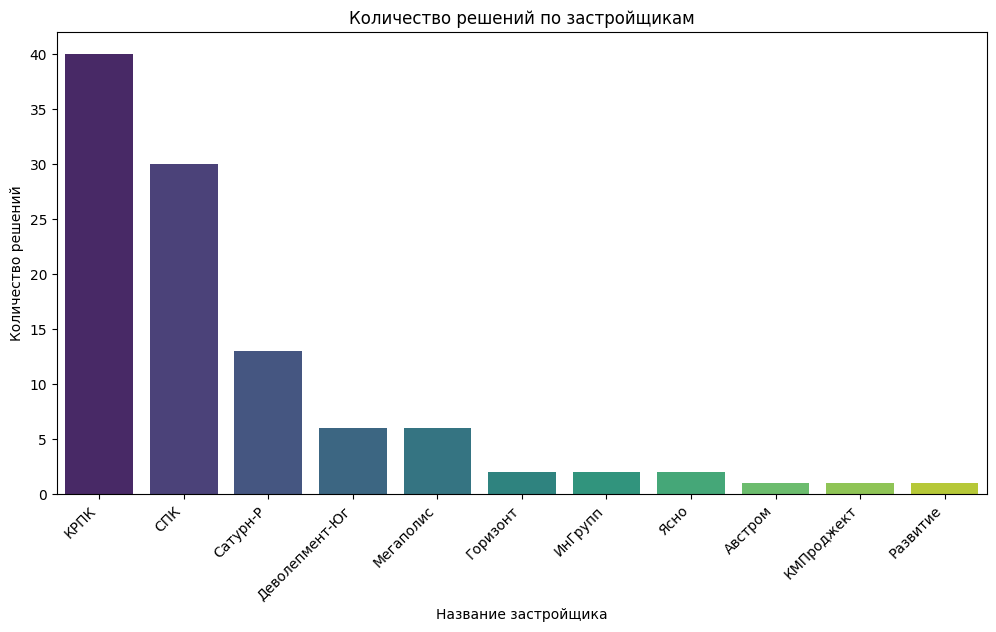

In [100]:
# готовим данные
count_developer = filtered_df.groupby('developer_name')['decision'].count().sort_values(ascending=False).reset_index()

# строим график
plt.figure(figsize=(12, 6))
sns.barplot(x='developer_name', y='decision', data=count_developer, palette='viridis')
plt.title('Количество решений по застройщикам')
plt.xlabel('Название застройщика')
plt.ylabel('Количество решений')
plt.xticks(rotation=45, ha='right')
plt.show()

**Вывод:** располагая данными лишь о половине судебных решений, удалось выделить двух застройщиков: Корпорация развития Пермского края и СтройПанельКомплект.

#### Данные о количестве комнат в квартирах

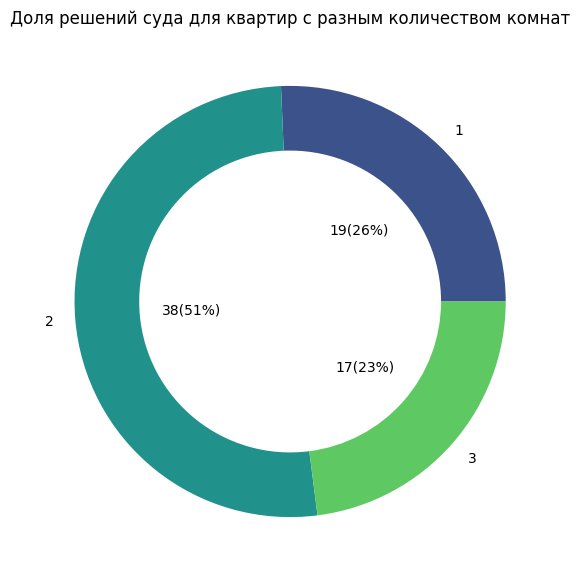

In [101]:
# готовим данные
rooms_count_df = filtered_df.pivot_table(index='rooms', values='decision', aggfunc='count')

# добавляем доли
rooms_count_sizes = rooms_count_df['decision']
rooms_count_labels = rooms_count_df.index

# добавляем цветовую палитру
colors = sns.color_palette("viridis", len(rooms_count_sizes))

plt.figure(figsize=(7, 7))
plt.pie(rooms_count_sizes, labels=rooms_count_labels, autopct=lambda p:f'{p*sum(rooms_count_sizes)/100 :.0f}({p:.0f}%)', pctdistance=0.46, wedgeprops=dict(width=0.3), colors=colors)
plt.title('Доля решений суда для квартир с разным количеством комнат')
plt.show()

**Вывод:** большинство квартир оказалось двухкомнатными. Примечательно, что среди них нет четырехкомнатных квартир.

#### Сколько занимает судебный процесс

In [102]:
# функция для разделения названия 
def split_name(name):
    # если длина названия больше 16 символов, ищем последний пробел до 16 символов
    if len(name) > 16:
        # ищем последний пробел до 16 символа
        split_index = name[:16].rfind(' ')
        # если пробел найден, делаем перенос строки на этом месте
        if split_index != -1:
            return name[:split_index] + '\n' + name[split_index+1:]
        # если пробел не найден, возвращаем исходное название с переносом на 16 символе
        else:
            return name[:16] + '\n' + name[16:]
    return name

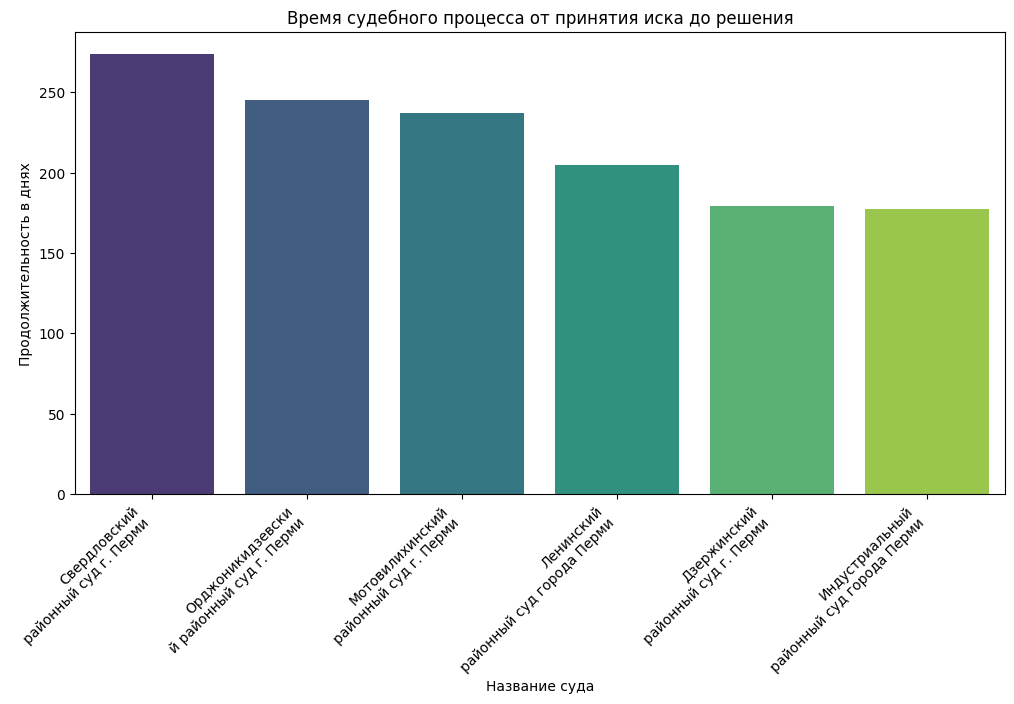

In [103]:
# готовим данные
filtered_df['duration'] = (filtered_df['result_date'] - filtered_df['entry_date']).dt.days
count_duration = filtered_df.groupby('court_name')['duration'].mean().sort_values(ascending=False).reset_index()

# строим график
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='court_name', y='duration', data=count_duration, palette='viridis')
plt.title('Время судебного процесса от принятия иска до решения')
plt.xlabel('Название суда')
plt.ylabel('Продолжительность в днях')
ax.set_xticklabels([split_name(name) for name in count_duration['court_name']])
plt.xticks(rotation=45, ha='right')
plt.show()

**Вывод:** Свердловский районный суд, вероятно, наиболее загружен — разбирательства в нём длятся в среднем восемь с половиной месяцев. Самые быстрые рассмотрения дел зафиксированы в Дзержинском и Индустриальном судах, где процесс занимает около шести месяцев.

#### Средняя сумма компенсации за дефекты на квадратный метр квартиры

In [104]:
# посмотрим распределение площади
filtered_df['area'].describe()

count    136.000000
mean      51.342353
std       70.860327
min        0.000000
25%       34.275000
50%       45.670000
75%       60.450000
max      840.320000
Name: area, dtype: float64

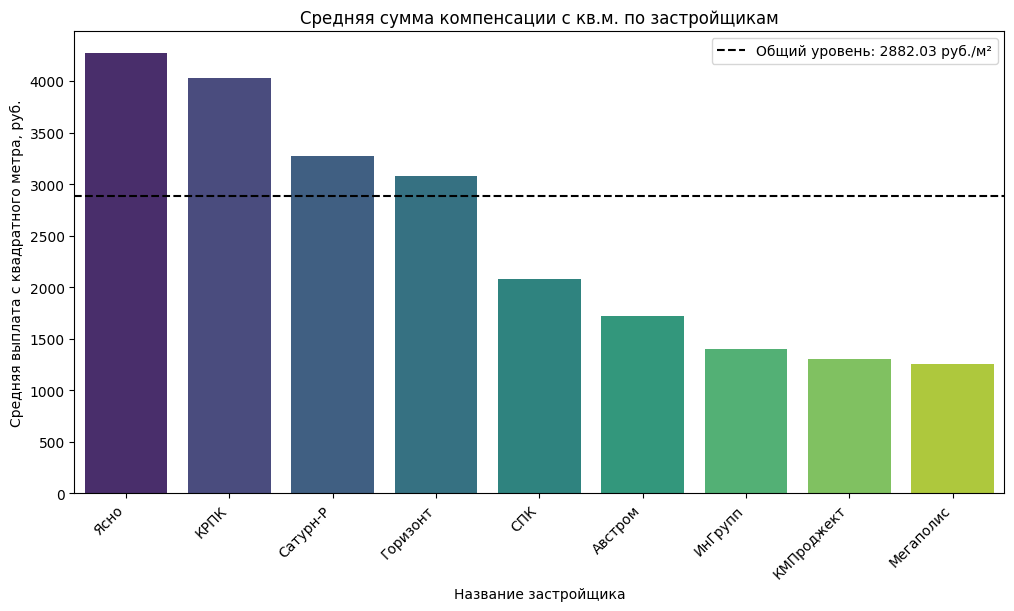

In [105]:
# фильтруем выбросы
filtered_area_df = filtered_df.loc[filtered_df['area'].between(33.6, 60.7)].copy()

# группируем по застройщикам и считаем сумму
area_mean_developer = (
    filtered_area_df.groupby('developer_name')[['area', 'defect_compensation_recovery']]
    .sum()
    .reset_index()
)

# рассчитываем среднее на квадратный метр для каждого застройщика
area_mean_developer['per_m'] = area_mean_developer['defect_compensation_recovery'] / area_mean_developer['area']
area_mean_developer = area_mean_developer[['developer_name', 'per_m']].sort_values(by='per_m', ascending=False)

# общая средняя компенсация на кв.м по всему датасету
overall_mean_per_m = (filtered_area_df['defect_compensation_recovery'].sum() / 
                      filtered_area_df['area'].sum())

# строим график
plt.figure(figsize=(12, 6))
sns.barplot(x='developer_name', y='per_m', data=area_mean_developer, palette='viridis')
# добавляем линию со средней компенсацией по всему датасету
plt.axhline(overall_mean_per_m, color='black', linestyle='--', label=f'Общий уровень: {overall_mean_per_m:.2f} руб./м²')
plt.title('Средняя сумма компенсации с кв.м. по застройщикам')
plt.xlabel('Название застройщика')
plt.ylabel('Средняя выплата с квадратного метра, руб.')
plt.xticks(rotation=45, ha='right')
plt.legend()

plt.show()

**Вывод:** лидирующие позиции застройщиков "Ясно" и "Горизонт", по количеству дефектов, могут быть связаны с небольшим числом решений. В то же время, "КРПК" и "Сатурн-Р" напротив выделяются значительным количеством судебных разбирательств и сумма компенсаций за недостатки выше среднего. Данные для графика взяты из решений суда, т.е. после судебной экспертизы.

#### Стоимость досудебной экспертизы

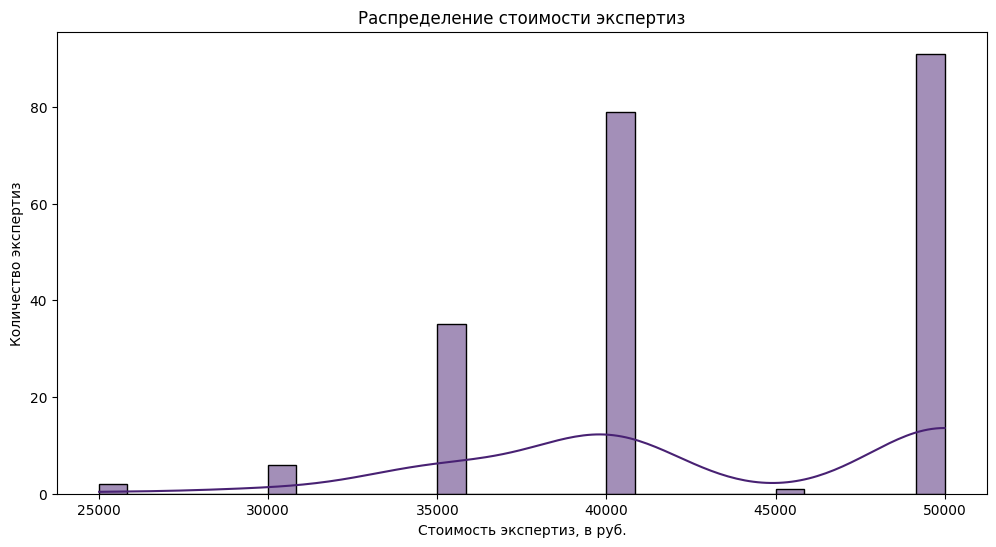

In [106]:
# извлекаем цвет из палитры 'viridis'
bin_color = sns.color_palette('viridis', 10)[0]

# строим гистограмму распределения стоимости экспертиз
plt.figure(figsize=(12, 6))
sns.histplot(filtered_df['expert_costs_demand'], kde=True, bins=30, color=bin_color)
plt.title('Распределение стоимости экспертиз')
plt.xlabel('Стоимость экспертиз, в руб.')
plt.ylabel('Количество экспертиз')
plt.show()


**Вывод:** наиболее распространенные суммы за проведение строительно-технической экспертизы составляют 40 000 руб. и 50 000 руб., при этом 50 000 руб. является максимальной стоимостью.

#### Исследуем разницу требуемых сумм и взысканных

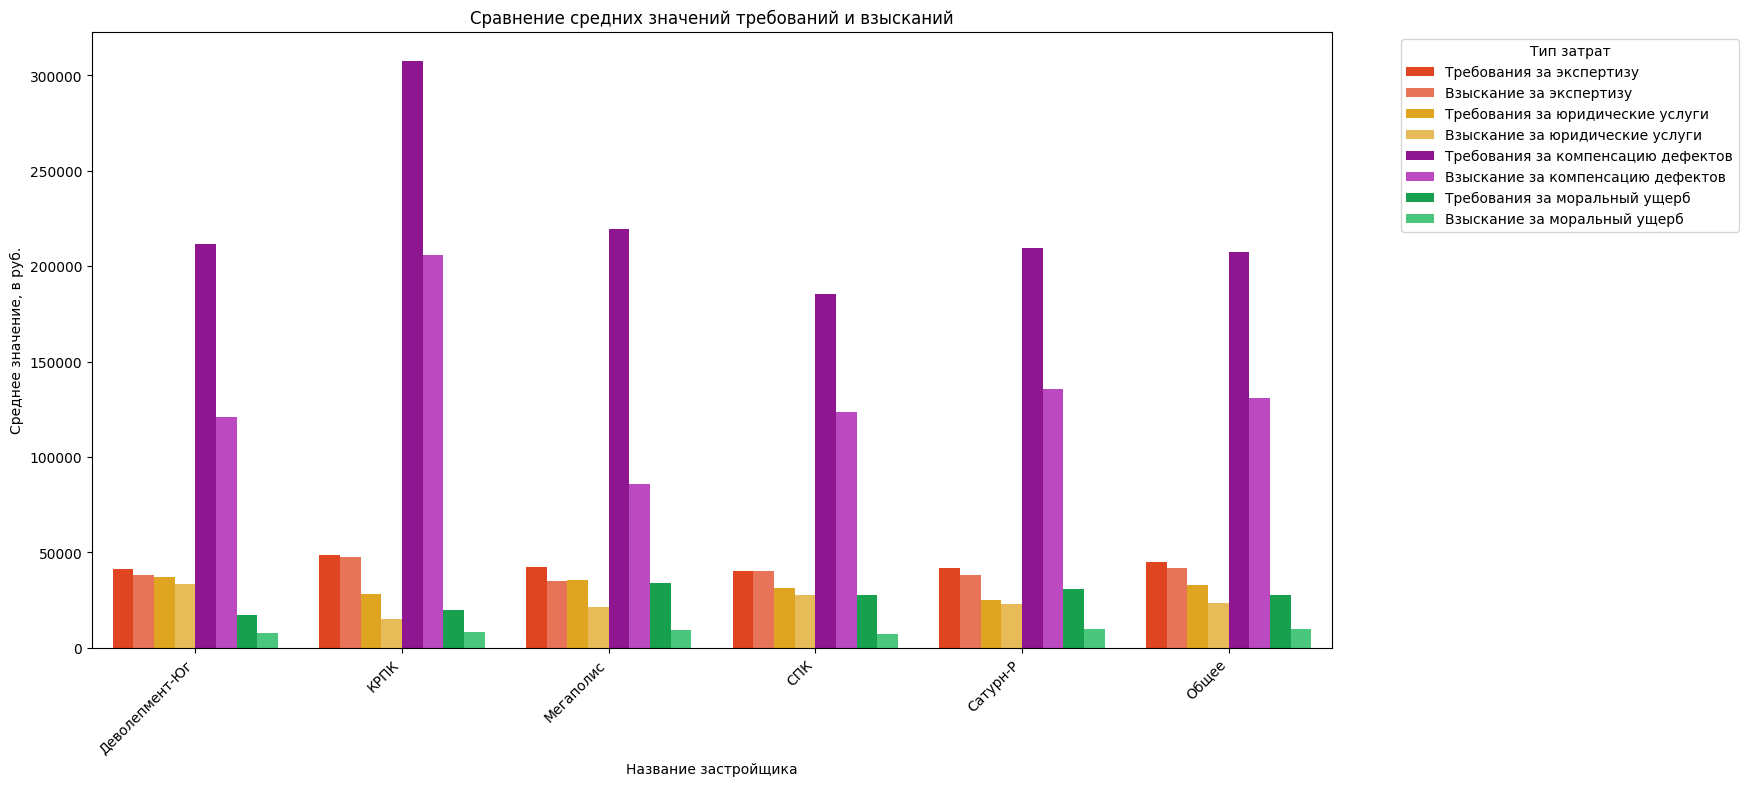

In [107]:
# создаем палитру из 4 пар контрастных цветов
custom_palette = [
    '#FF3100', '#FF6440',  
    '#FFB000', '#FFC440',  
    '#A101A6', '#CD35D3',  
    '#00B74A', '#37DB79'   
]

# создаем пары столбцов
pair_columns = [
    ('expert_costs_demand', 'expert_costs_recovery'),
    ('laweyr_costs_demand', 'laweyr_costs_recovery'),
    ('defect_compensation_demand', 'defect_compensation_recovery'),
    ('moral_damage_demand', 'moral_damage_recovery')
]

# преобразуем данные
paired_data = []

for demand_col, recovery_col in pair_columns:
    temp_df = filtered_df.groupby('developer_name')[[demand_col, recovery_col]].mean().reset_index()
    
    # Добавляем общую среднюю строку
    overall_mean = temp_df[[demand_col, recovery_col]].mean().to_frame().T
    overall_mean['developer_name'] = 'Общее'
    
    temp_df = pd.concat([temp_df, overall_mean], ignore_index=True)
    
    temp_df = temp_df.melt(
        id_vars='developer_name', 
        var_name='сategory', 
        value_name='average_value'
    )
    # перевод 'сategory' на русский
    temp_df['сategory'] = temp_df['сategory'].replace({
        'expert_costs_demand': 'Требования за экспертизу',
        'expert_costs_recovery': 'Взыскание за экспертизу',
        'laweyr_costs_demand': 'Требования за юридические услуги',
        'laweyr_costs_recovery': 'Взыскание за юридические услуги',
        'defect_compensation_demand': 'Требования за компенсацию дефектов',
        'defect_compensation_recovery': 'Взыскание за компенсацию дефектов',
        'moral_damage_demand': 'Требования за моральный ущерб',
        'moral_damage_recovery': 'Взыскание за моральный ущерб'
    })
    
    paired_data.append(temp_df)

# объединяем все пары
paired_df = pd.concat(paired_data, ignore_index=True)

# оставляем топ-5 застройщиков + 'Общее'
top_developers = filtered_df.groupby('developer_name')['decision'].count().nlargest(5).index.tolist()
top_developers.append('Общее')

paired_df = paired_df[paired_df['developer_name'].isin(top_developers)]

# строим график
plt.figure(figsize=(16, 8))
sns.barplot(
    x='developer_name', 
    y='average_value', 
    hue='сategory', 
    data=paired_df, 
    palette=custom_palette
)

plt.title('Сравнение средних значений требований и взысканий')
plt.xlabel('Название застройщика')
plt.ylabel('Среднее значение, в руб.')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Тип затрат', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

**Вывод:** можно отметить, что требования за расходы на экспертизу, как правило, удовлетворяются в полном или почти полном объеме, за исключением случаев с застройщиком Мегаполис. Требования за расходы на представителя обычно удовлетворяются в меньшей степени, и в некоторых случаях, например, по застройщику КРПК, они составляют лишь половину от запрашиваемой суммы.

Компенсация за моральный вред, как правило, выплачивается в меньшем объеме по сравнению с основными суммами. Разница по этим трем позициям среди застройщиков не является значительной.

В отношении взыскания компенсации за устранение дефектов сумма, указанная в решении, часто оказывается на треть меньше требуемой. Особо выделяется застройщик КРПК по абсолютным суммам и застройщик Мегаполис по объему взысканной компенсации, который составляет менее 50%

#### Исследуем разницу требований основной суммы и взыскания компенсации вместе с штрафом и неустойкой

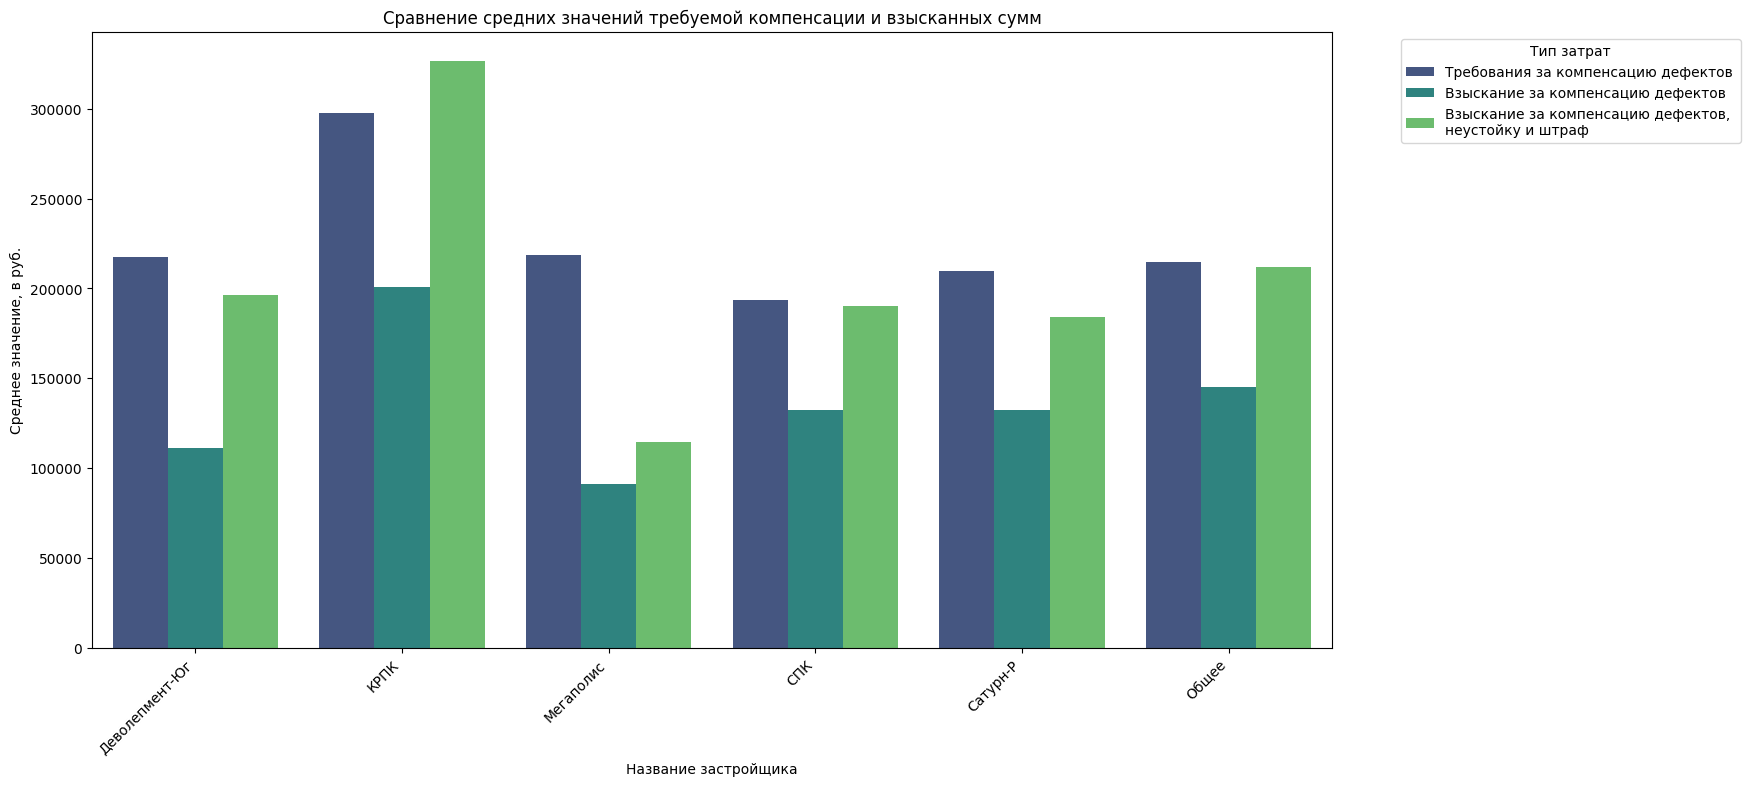

In [108]:
# добавляем новую колонку Total Compensation (сумма трех колонок)
filtered_df['total_compensation_recovery'] = (
    filtered_df['defect_compensation_recovery'] + 
    filtered_df['liquidated_recovery'] + 
    filtered_df['penalty_recovery']
)

# список столбцов
triple_columns = [
    ('defect_compensation_demand', 'defect_compensation_recovery', 'total_compensation_recovery')
]

# преобразуем данные
paired_data = []

for demand_col, recovery_col, total_col in triple_columns:
    temp_df = filtered_df[filtered_df['total_compensation_recovery'].notna()].groupby('developer_name')[[demand_col, recovery_col, total_col]].mean().reset_index()
    
    # добавляем общую среднюю строку
    overall_mean = temp_df[[demand_col, recovery_col, total_col]].mean().to_frame().T
    overall_mean['developer_name'] = 'Общее'
    
    temp_df = pd.concat([temp_df, overall_mean], ignore_index=True)
    
    temp_df = temp_df.melt(
        id_vars='developer_name', 
        var_name='category', 
        value_name='average_value'
    )
    # перевод'сategory' на русский
    temp_df['category'] = temp_df['category'].replace({
        'defect_compensation_demand': 'Требования за компенсацию дефектов',
        'defect_compensation_recovery': 'Взыскание за компенсацию дефектов',
        'total_compensation_recovery': 'Взыскание за компенсацию дефектов, \nнеустойку и штраф'
    })
    paired_data.append(temp_df)

# объединяем все значения
paired_df = pd.concat(paired_data, ignore_index=True)

# оставляем топ-5 застройщиков + 'Общее'
top_developers = filtered_df.groupby('developer_name')['decision'].count().nlargest(5).index.tolist()
top_developers.append('Общее')

paired_df = paired_df[paired_df['developer_name'].isin(top_developers)]

# строим график
plt.figure(figsize=(16, 8))
sns.barplot(
    x='developer_name', 
    y='average_value', 
    hue='category', 
    data=paired_df, 
    palette='viridis'
)

plt.title('Сравнение средних значений требуемой компенсации и взысканных сумм')
plt.xlabel('Название застройщика')
plt.ylabel('Среднее значение, в руб.')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Тип затрат', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

**Вывод:** если сложить суммы неустойки и штрафа с компенсацией за дефекты, то общая сумма в среднем приближается к требованиям, заявленным изначально. Без учета дополнительных сумм компенсация после независимой экспертизы, как правило, составляет около двух третей от желаемой суммы.

### Шаг 6. <a id="conclusion">Общий вывод</a> 

На основе анализа судебных решений, можно выделить несколько ключевых тенденций. Из данных о половине решений удалось выделить два застройщика по количеству процессов: "Корпорация развития Пермского края" и "СтройПанельКомплект". Половина квартир оказалось двухкомнатными, однокомнатные и трехкомнатные занимают доли около одной четвертой. Свердловский районный суд отличается наиболее длительным процессом, в то время как Дзержинский и Индустриальный суды характеризуются быстрыми разбирательствами. Можно ориентировать на диапазон от шести до девяти месяцев до выхода на решение суда.

Дефектов выше среднего у следующих застройщиков: "Ясно", "Корпорация развития Пермского края", "Сатурн-Р", "Горизонт". В тоже время застройщик "СтройПанельКомплект" являясь вторым по количеству дел, имеет среднее количество дефектов существенно меньше среднего - около 2100 тыс.руб./кв.м., против 2800-2900 тыс. руб./кв.м. в среднем для всех решений(где есть данные о площади).

Рыночные суммы за строительно-техническую экспертизу составляют 40 000 и 50 000 руб., при этом 50 000 руб. является максимальной стоимостью.

Требования за расходы на экспертизу обычно удовлетворяются в полном объеме, за исключением случаев с застройщиком "Мегаполис". Расходы на представителя удовлетворяются в меньшем объеме, и в некоторых случаях, как у "КРПК", составляют лишь половину от запрашиваемой суммы. Компенсация за моральный вред, как правило, меньше основных сумм, но разница по этим трем позициям незначительная среди застройщиков. В отношении компенсации за дефекты сумма часто оказывается на треть меньше требуемой, при этом выделяются застройщики "КРПК" по абсолютным суммам и "Мегаполис" по объему взысканной компенсации, составляющей менее 50%.

Если учесть неустойку и штрафы, то общая сумма требований приближается к изначальным. Однако, без дополнительных сумм, компенсация после судебной экспертизы составляет около двух третей от желаемой суммы.